# Formating the Data


This code uses a modified Bloomberg report. The Excel file was altered by removing the first three rows (or deleting all rows above the names of the stock) and saving the file as a CSV. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys
import scipy
from scipy.stats import binom, hypergeom
from dateutil.parser import parse
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go
# This variable determines whether the match list is exported to the Google Drive
export = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


[link text](https://)This is the part of the code that breaks up the data into the two time sections. dfstunted is the training data and dftesting is the later time period.

Given that the table only includes the headers and the data, this algorithm will create a nested dataframe from the spreadsheet saved as a CSV.

The algorithm for wrangling the data was borrowed from <https://stackoverflow.com/questions/30322581/pandas-read-multiindexed-csv-with-blanks/30325965#30325965?newreg=c289da9a24ac440c99d1418fd73121b9.>

In [ ]:
'''This is where the data is imported and turned into a multiindex Pandas DataFrame.
As stated above, the data from Bloomberg has to be edited in Excel and saved as
a csv before being imported here. This means deleting the all rows before the 
name of the companies and all columns before the date. In practice, you may need
to delete day 1 as well as it tends to call a name error.'''

#First import into a two row column df
df= pd.read_csv('drive/My Drive/portfoliosnorgeusa.csv', mangle_dupe_cols=True, header = [0,1])
# Turn the columns into a list
columns = pd.DataFrame(df.columns.tolist())
# transform the unnamed columns into np.nan 
columns.loc[columns[0].str.startswith('Unnamed:'), 0] = np.nan
# fills the np.nan with empty columns
columns[0] = columns[0].fillna(method='ffill')
mask = pd.isnull(columns[0])
columns[0] = columns[0].fillna('')
columns.loc[mask, [0,1]] = columns.loc[mask, [1,0]].values
# Transform the data back into a multiindex 
df.columns = pd.MultiIndex.from_tuples(columns.to_records(index=False).tolist())
# Transform the date values into date format
df['Dates']= [parse(i).date() for i in df['Dates']]
end_date = '1/3/2018'
# Seperate the data into before the date and after date
mask = df['Dates'] <= parse(end_date).date()
mask2 = df['Dates'] > parse(end_date).date()
dfstunted=df.loc[mask] #data before the cut off
dftesting = df.loc[mask2] #data after the cut off


## Grouping By Industry

In [ ]:
industries= pd.read_csv('drive/My Drive/GICS.csv', index_col=0)
industries= industries.dropna(axis=0, how='all')
industries=industries.transpose()

In [ ]:
industries=industries.GICS_SECTOR_NAME.str.get_dummies()

## Flattening the Data
The below code flattens the data to be used in KDTree

In [ ]:
testlist={}
controllist={}
# This loops through the company names
for i in set(dfstunted.index): 
    # Call the before data for given company
    data = dfstunted.loc[i].reset_index()
    data= data.pivot(index= 'level_0', columns='level_1', values=i).reset_index()
    # Pivot the dataframe
    data = data.drop(labels= None, axis= 1, columns= '')
    # Encode the US stocks as such and Norway stocks as such
    data['MARKET']= pd.np.where(data['level_0'].str.contains("US Equity"), "US", "NO")
    # seperate the data into two datasets - one for Norway, one for US
    test = data[data.MARKET == "NO"] # test is the Norway Stocks
    control = data[data.MARKET == "US"] # control is the US stocks
    test['MARKET'] = 1
    control['MARKET'] = 0
    if i == 0:
      mastertest = test
      mastercontrol= control
      continue
    # Flatten the data into a row per company
    # Include AVERAGE BID ASK SPREAD, TURNOVER, PX VOLUME, VWAP NUM TRADES, VOLATILITY_10D, CUR_MKT_CA and PX_LAST 
    #mastertest['AVERAGE_BID_ASK_SPREAD_%s' % i]= test['AVERAGE_BID_ASK_SPREAD']
    mastertest['CUR_MKT_CAP_%s' % i]= test['CUR_MKT_CAP']
    #mastertest['PX_LAST_%s' % i]= test['PX_LAST']
    #mastertest['PX_VOLUME_%s' % i]= test['PX_VOLUME']
    # mastertest['TOT_ANALYST_REC_%s' % i]= test['TOT_ANALYST_REC']
    #mastertest['TURNOVER _%s' % i]= test['TURNOVER']
    mastertest['VWAP_NUM_TRADES_%s' % i]= test['VWAP_NUM_TRADES']
    mastertest['VOLATILITY_10D_%s' % i]= test['VOLATILITY_10D']
    for industry in industries.columns:
      mastertest[industry]=industries[industry][data['level_0']]*1000


    #mastercontrol['AVERAGE_BID_ASK_SPREAD_%s' % i]= control['AVERAGE_BID_ASK_SPREAD']
    mastercontrol['CUR_MKT_CAP_%s' % i]= control['CUR_MKT_CAP']
    #mastercontrol['PX_LAST_%s' % i]= control['PX_LAST']
    #mastercontrol['PX_VOLUME_%s' % i]= control['PX_VOLUME']
    # mastercontrol['TOT_ANALYST_REC_%s' % i]= control['TOT_ANALYST_REC']
    #mastercontrol['TURNOVER _%s' % i]= control['TURNOVER']
    mastercontrol['VWAP_NUM_TRADES_%s' % i]= control['VWAP_NUM_TRADES']
    mastercontrol['VOLATILITY_10D_%s' % i]= control['VOLATILITY_10D']
    for industry in industries.columns:
      mastercontrol[industry]=industries[industry][data['level_0']]*1000
mastercontrol=mastercontrol.drop(['AVERAGE_BID_ASK_SPREAD'], axis=1).fillna(0)
mastertest= mastertest.drop(['AVERAGE_BID_ASK_SPREAD'], axis=1).fillna(0)
mastercontrol=mastercontrol.reset_index().drop(['index'], axis=1)
mastertest= mastertest.reset_index().drop(['index'], axis=1)
#convert the data frame into a matrix
testarray= mastertest.drop(['level_0'], axis=1).values
controlarray= mastercontrol.drop(['level_0'], axis=1).values

In [ ]:
# convert the value types due to issues in the excel file
testarray=mastertest.iloc[:,2:].values
teststocknames = mastertest['level_0'].values
controlstocknames = mastercontrol['level_0'].values
controlarray=mastercontrol.iloc[:,2:].values
testarray= testarray.astype(float)
controlarray = controlarray.astype(float)

In [ ]:
# getting rid of non-number values
import numpy.ma as ma
testarray=  np.where(np.isnan(testarray), ma.array(testarray, mask=np.isnan(testarray)).mean(axis=0), testarray)
controlarray=  np.where(np.isnan(controlarray), ma.array(controlarray, mask=np.isnan(controlarray)).mean(axis=0), controlarray)

# The Nearest Neighbors

In [ ]:
# Set up KDTree
from sklearn.neighbors import KDTree
# Make the tree
kdtree=KDTree(controlarray)
# query the tree for the match
dist,points=kdtree.query(testarray,k = 1)

In [ ]:
# use the made matches to make a list of matches in a dataframe 
matchlist2=[]
for i in range(len(points)):
  matchlist2.append([mastertest['level_0'][i],mastercontrol['level_0'][points[i][0]]])
matchlist2= pd.DataFrame(matchlist2)


In [ ]:
if export:
  matchlist2.to_csv('drive/My Drive/matchlist2.csv')

In [ ]:

matchlist2

,0,1
0,ABT NO Equity,CHCT US Equity
1,AFG NO Equity,FORR US Equity
2,AKA NO Equity,CHCT US Equity
3,AKER NO Equity,EIG US Equity
4,AKERBP NO Equity,ATO US Equity
...,...,...
92,VEI NO Equity,BCPC US Equity
93,WWI NO Equity,PPBI US Equity
94,XXL NO Equity,BIO US Equity
95,YAR NO Equity,DUK US Equity


# Clustering into Three Groups

Clustering based on the z score. A skewed right distribution.

In [ ]:
from scipy.stats import zscore
mastertest['ZSCORE']=zscore(mastertest['CUR_MKT_CAP'])
zscoredf=pd.DataFrame(mastertest[['level_0','ZSCORE']])

In [ ]:
zscoredf['SMALLCAP']=np.where((zscoredf['ZSCORE'] < -.25), 1, 0)
zscoredf['MIDCAP']=np.where((zscoredf['ZSCORE'].between(-.25,.5)==True),1,0)
zscoredf['LARGECAP']=np.where((zscoredf['ZSCORE']>=.5),1,0)
matchlist2=matchlist2.join(zscoredf)
if matchlist2[matchlist2[0]==matchlist2['level_0']][0].count()!=matchlist2[0].count():
  raise "Error processing groups, please contact developer"
matchlist2= matchlist2.drop(columns=['level_0'])

# Setting up Difference in Difference

In [ ]:
testing=False
del df

In [ ]:

# Calling the 2nd data set with the caluculate LQ3 and reformatting it 
#just like the first dataset
df= pd.read_csv('drive/My Drive/FinalData.csv', mangle_dupe_cols=True, header = [0,1])
df=df.drop(labels=0, axis =0)
columns = pd.DataFrame(df.columns.tolist())
columns.loc[columns[0].str.startswith('Unnamed:'), 0] = np.nan
columns[0] = columns[0].fillna(method='ffill')
mask = pd.isnull(columns[0])
columns[0] = columns[0].fillna('')
columns.loc[mask, [0,1]] = columns.loc[mask, [1,0]].values
df.columns = pd.MultiIndex.from_tuples(columns.to_records(index=False).tolist())
df = df.loc[:,~df.columns.duplicated()]
df['Dates']= [parse(i).date() for i in df['Dates']]
for i in df.columns:
  if i[1]== 'CUR_MKT_CAP':
    df[i[0],'LQ3']=df[i[0], 'CHG_NET_1D']/(df[i[0], 'VWAP_NUM_TRADES']+.0001)
    df[i[0],'LQ3']=df[i[0],'LQ3'].fillna(0.0001)
    df[i[0],'LQ3']=df[i[0],'LQ3']+.0001
    df[i[0],'REL_BID_ASK_SPREAD']=df[i[0], 'AVERAGE_BID_ASK_SPREAD']/df[i[0], 'PX_LAST']

In [ ]:
df

Dates STB NO Equity  ... OI US Equity                   
                      TURNOVER  ...          LQ3 REL_BID_ASK_SPREAD
1     2016-05-01      73166350  ...     0.000029           0.000651
2     2016-06-01      89256210  ...     0.000046           0.000675
3     2016-07-01     114017400  ...     0.000054           0.000691
4     2016-08-01      49154010  ...     0.000066           0.000686
5     2016-11-01      45628060  ...     0.000062           0.000698
...          ...           ...  ...          ...                ...
1040  2019-12-30      49689320  ...     0.000093           0.000862
1041  2019-12-31      49689320  ...     0.000115           0.000855
1042  2020-01-01      49689320  ...     0.000115           0.000855
1043  2020-02-01      60017410  ...     0.000074           0.000862
1044  2020-03-01      42391320  ...     0.000111           0.000872

[1044 rows x 16732 columns]

In [ ]:
from statsmodels.formula.api import ols
import numpy as np
# This tries to fix the excel file
def clear_error(a):
    if a == '#NAME?':
      return float(0)
    else:
      return float(a)

def diff_in_diff(KeyColumn): # This is the regression
  try:
    del turnover
    del turnover1
    del temp
  except:
    pass
  for index, row in matchlist2.iterrows():
    i=row[0]
    j=row[1]
    # the loops tries to go through dates, this skips it
    if j == 'Dates':
      continue
    if i in ['Dates']:
      continue
    try:
      # This is the operations for all but the first match
      temp=pd.DataFrame(df[i][KeyColumn])
      temp['Date']=df['Dates']
      temp['TEST_GROUP']=1
      temp['SMALLCAP']=row['SMALLCAP']
      temp['MIDCAP']=row['MIDCAP']
      temp['LARGECAP']=row['LARGECAP']
      turnover=pd.concat([turnover,temp])
    except:
      # this is the first match operation
      turnover=df[i][KeyColumn]
      turnover=pd.DataFrame(turnover)

      turnover['Date']=df['Dates']
      turnover['TEST_GROUP']=1
      turnover['SMALLCAP']=row['SMALLCAP']
      turnover['MIDCAP']=row['MIDCAP']
      turnover['LARGECAP']=row['LARGECAP']
    temp2=pd.DataFrame(df[j][KeyColumn])
    temp2['Date']= df['Dates']
    temp2['SMALLCAP']=row['SMALLCAP']
    temp2['MIDCAP']=row['MIDCAP']
    temp2['LARGECAP']=row['LARGECAP']
    temp2['TEST_GROUP']=0
    turnover=pd.concat([turnover, temp2])
  # increases the value of the total analyst rec by 1 in order to make logistic regression possible 
  if KeyColumn == 'TOT_ANALYST_REC':
    turnover[KeyColumn]=turnover[KeyColumn]+1
  if KeyColumn == 'AVERAGE_BID_ASK_SPREAD':
    turnover[KeyColumn]=turnover[KeyColumn]+1
  # manipulates the value of LQ3 so that it can use logistic regression
  # if KeyColumn == 'LQ3':
  #   turnover[KeyColumn]=turnover[KeyColumn]*10+1
  turnover['Date']= pd.to_datetime(turnover['Date'])
  turnover['TREATMENT'] = np.where((turnover['Date'] > '2018-01-03'), 1, 0)
  turnover['DAY_DELTA'] = (turnover.Date - turnover.Date.min()).dt.days
  turnover['DID']=turnover['TEST_GROUP']*turnover['TREATMENT']
  turnover['SMALLORMID']=turnover['SMALLCAP']+turnover['MIDCAP']
  turnover[KeyColumn]=turnover[KeyColumn].apply(clear_error)
  if testing:
    print(turnover)
  #LQ3 does not work with the log equations
  if 1==0:
    pass
  # if KeyColumn=="LQ3":
  #    stringmethod=KeyColumn + " ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + DAY_DELTA"
  #    stringmethod2=KeyColumn + " ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + SMALLCAP + SMALLCAP * TREATMENT + SMALLCAP * TEST_GROUP + SMALLCAP * TREATMENT * TEST_GROUP + DAY_DELTA"
  #    stringmethod3=KeyColumn + " ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + MIDCAP + MIDCAP * TREATMENT + MIDCAP * TEST_GROUP + MIDCAP * TREATMENT * TEST_GROUP + DAY_DELTA"
  #    stringmethod4=KeyColumn + " ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + LARGECAP + LARGECAP * TREATMENT + LARGECAP * TEST_GROUP + LARGECAP * TREATMENT * TEST_GROUP + DAY_DELTA"
  else:
    stringmethod='np.log('+KeyColumn + ") ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + DAY_DELTA"
    stringmethod2='np.log('+KeyColumn + ") ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + SMALLCAP + SMALLCAP * TREATMENT + SMALLCAP * TEST_GROUP + SMALLCAP * TREATMENT * TEST_GROUP + DAY_DELTA"
    stringmethod3='np.log('+KeyColumn + ") ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + MIDCAP + MIDCAP * TREATMENT + MIDCAP * TEST_GROUP + MIDCAP * TREATMENT * TEST_GROUP + DAY_DELTA"
    stringmethod4='np.log('+KeyColumn + ") ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + LARGECAP + LARGECAP * TREATMENT + LARGECAP * TEST_GROUP + LARGECAP * TREATMENT * TEST_GROUP + DAY_DELTA"
  model = ols(stringmethod, data=turnover)
  model2 = ols(stringmethod2, data=turnover)
  model3 = ols(stringmethod3, data=turnover)
  model4 = ols(stringmethod4, data=turnover)
  
  keydf= turnover[[KeyColumn, 'TEST_GROUP', 'TREATMENT', 'Date']]
  dfcontrol=keydf.loc[keydf['TEST_GROUP']==0];dftest=keydf.loc[keydf['TEST_GROUP']==1]
  masterdf=dfcontrol
  masterdf['CONTROL']=masterdf[KeyColumn]
  masterdf['TEST']=dftest[KeyColumn]
  masterdf['LOG_CONTROL']=np.log(masterdf['CONTROL'])
  masterdf['LOG_TEST']=np.log(masterdf['TEST'])
  predf=masterdf.loc[masterdf['TREATMENT']==0]
  postdf=masterdf.loc[masterdf['TREATMENT']==1]
  results = model.fit()
  results2 = model2.fit()
  results3 = model3.fit()
  results4 = model4.fit()
  aggregatedf=masterdf.groupby(['Date']).mean()
  aggregatedf=aggregatedf.drop(['TEST_GROUP', KeyColumn], axis=1)
  aggregatedf=aggregatedf.rolling(30).mean()
  aggregatedf=aggregatedf.reset_index()
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=aggregatedf['Date'], y=aggregatedf['LOG_TEST'], name='OSLO_'+KeyColumn,
                         line=dict(color='firebrick', width=4)))
  fig.add_trace(go.Scatter(x=aggregatedf['Date'], y=aggregatedf['LOG_CONTROL'], name='US_'+KeyColumn,
                         line=dict(color='royalblue', width=4)))
  
  mini=aggregatedf['LOG_CONTROL'].min()if aggregatedf['LOG_CONTROL'].min()< aggregatedf['LOG_TEST'].min() else aggregatedf['LOG_TEST'].min()
  maxi=aggregatedf['LOG_CONTROL'].max()if aggregatedf['LOG_CONTROL'].max()> aggregatedf['LOG_TEST'].max() else aggregatedf['LOG_TEST'].max()
  fig.add_shape(
          # Line Vertical
          dict(
              type="line",
              x0='2018-01-03',
              y0=mini,
              x1='2018-01-03',
              y1=maxi,
              line=dict(
                  color="Black",
                  width=3 )
  ))
  predfstats = predf[['CONTROL', 'TEST']].describe()
  postdfstats= postdf[['CONTROL', 'TEST']].describe()
  del turnover
  del temp
  return results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats

In [ ]:
# Tool to get the tables
def strtotable(strish):
  strish=strish.replace('\t', ' | ')
  strish='''|Variable | coef |	std err |	t |	P-value |	0.025 |	0.975 |
|---|---|---|---|---|---|---|'''+'\n'+strish+'\n'+'Significant at $\alpha$=0.001***|'
  return(strish)


# OLS Results

***bold text***## Turnover

In [ ]:
testing=False
results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats= diff_in_diff('TURNOVER')

### Summary Statistics

In [ ]:
predfstats

,CONTROL,TEST
count,4.959000e+04,5.011200e+04
mean,2.508913e+07,3.515120e+07
std,6.632809e+07,9.788988e+07
min,3.739047e+04,1.600000e+00
25%,1.292893e+06,5.061180e+05
50%,3.958537e+06,3.481542e+06
75%,1.497374e+07,1.867588e+07
max,2.327698e+09,4.265468e+09


In [ ]:
postdfstats

,CONTROL,TEST
count,4.959000e+04,5.011200e+04
mean,3.400380e+07,4.279772e+07
std,1.048326e+08,1.067421e+08
min,9.961104e+04,3.720000e+00
25%,2.937112e+06,5.663207e+05
50%,5.921393e+06,4.878732e+06
75%,1.887251e+07,3.205880e+07
max,1.072328e+10,4.559098e+09


### Kernal Density Pre-Treatment

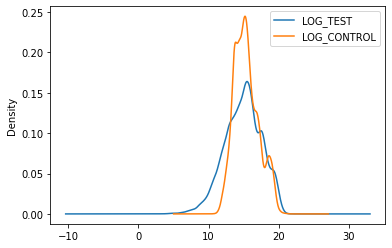

In [ ]:
predf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Kernal Density Post-Treatment

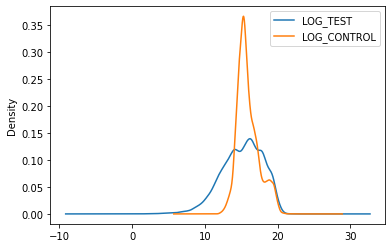

In [ ]:
postdf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Trendline

In [ ]:
fig.show()

### Difference in Difference

log(TURNOVER) = $\beta_{0}$ + $\beta_{1}$dO + $\delta_{0}$dT + $\delta_{1}$dO*dT + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$(dO*dT)|TEST_GROUP:TREATMENT| Difference in Difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(TURNOVER)   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1495.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:52:45   Log-Likelihood:            -4.4534e+05
No. Observations:              199404   AIC:                         8.907e+05
Df Residuals:                  199399   BIC:                         8.907e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               15.2595      0.013   1135.988      0.000      15.233      15.286
TEST_GROUP              -0.4971      0.014    -34.755      0.000      -0.525      -0.469
TREATMENT                0.2614      0.023     11.541      0.000       0.217       0.306
TEST_GROUP:TREATMENT    -0.3050      0.020    -15.079      0.000      -0.345      -0.265
DAY_DELTA                0.0004    2.4e-05     15.337      0.000       0.000       0.000
==============================================================================
Omnibus:                     6237.888   Durbin-Watson:                   0.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9892.494
Skew:                          -0.299   Prob(JB):                         0.00
Kurtosis:                       3.912   Cond. No.                     4.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.2595,0.013000,1135.988,0.0,15.233,15.286
TEST_GROUP,-0.4971,0.014000,-34.755,0.0,-0.525,-0.469
TREATMENT,0.2614,0.023000,11.541,0.0,0.217,0.306
TEST_GROUP:TREATMENT,-0.3050,0.020000,-15.079,0.0,-0.345,-0.265
DAY_DELTA,0.0004,0.000024,15.337,0.0,0.000,0.000


### Difference in Difference in Difference- Small Cap

log(TURNOVER) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|SMALLCAP|True if company classified as small
|$\delta_{3}$dO * dS| SMALLCAP:TREATMENT| True if post-treatment and small company
|$\beta_{3}$dO * dS|SMALLCAP:TEST_GROUP| True if company from Norway and classified as small|
|$\delta_{3}$dO * dT * dS|SMALLCAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary2 = results2.summary()
results_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(TURNOVER)   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                 1.632e+04
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:52:45   Log-Likelihood:            -3.9806e+05
No. Observations:              199404   AIC:                         7.961e+05
Df Residuals:                  199395   BIC:                         7.962e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        16.4249      0.014   1192.593      0.000      16.398      16.452
TEST_GROUP                        0.2090      0.017     12.504      0.000       0.176       0.242
TREATMENT                         0.0241      0.022      1.109      0.267      -0.019       0.067
TEST_GROUP:TREATMENT             -0.0942      0.024     -3.985      0.000      -0.141      -0.048
SMALLCAP                         -2.1291      0.016   -132.486      0.000      -2.161      -2.098
SMALLCAP:TREATMENT                0.4335      0.023     19.074      0.000       0.389       0.478
SMALLCAP:TEST_GROUP              -1.3260      0.023    -58.527      0.000      -1.370      -1.282
SMALLCAP:TREATMENT:TEST_GROUP    -0.3845      0.032    -12.001      0.000      -0.447      -0.322
DAY_DELTA                         0.0004   1.89e-05     19.441      0.000       0.000       0.000
==============================================================================
Omnibus:                    10687.644   Durbin-Watson:                   0.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22740.539
Skew:                          -0.368   Prob(JB):                         0.00
Kurtosis:                       4.482   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html2 = results_summary2.tables[1].as_html()
dd= pd.read_html(results_as_html2, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,16.4249,0.014000,1192.593,0.000,16.398,16.452,1642.49
TEST_GROUP,0.2090,0.017000,12.504,0.000,0.176,0.242,20.90
TREATMENT,0.0241,0.022000,1.109,0.267,-0.019,0.067,2.41
TEST_GROUP:TREATMENT,-0.0942,0.024000,-3.985,0.000,-0.141,-0.048,-9.42
SMALLCAP,-2.1291,0.016000,-132.486,0.000,-2.161,-2.098,-212.91
SMALLCAP:TREATMENT,0.4335,0.023000,19.074,0.000,0.389,0.478,43.35
SMALLCAP:TEST_GROUP,-1.3260,0.023000,-58.527,0.000,-1.370,-1.282,-132.60
SMALLCAP:TREATMENT:TEST_GROUP,-0.3845,0.032000,-12.001,0.000,-0.447,-0.322,-38.45
DAY_DELTA,0.0004,0.000019,19.441,0.000,0.000,0.000,0.04


### Difference in Difference in Difference- Middle Cap

log(TURNOVER) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|MIDCAP|True if company classified as midcap
|$\delta_{3}$dO * dS| MIDAP:TREATMENT| True if post-treatment and a midcap company
|$\beta_{3}$dO * dS|MIDCAP:TEST_GROUP| True if company from Norway and classified as midcap|
|$\delta_{3}$dO * dT * dS|MIDCAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary3=results3.summary()
results_summary3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(TURNOVER)   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     4720.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:52:45   Log-Likelihood:            -4.3099e+05
No. Observations:              199404   AIC:                         8.620e+05
Df Residuals:                  199395   BIC:                         8.621e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      14.7913      0.015   1019.281      0.000      14.763      14.820
TEST_GROUP                     -0.8353      0.017    -49.539      0.000      -0.868      -0.802
TREATMENT                       0.3986      0.024     16.949      0.000       0.352       0.445
TEST_GROUP:TREATMENT           -0.4485      0.024    -18.809      0.000      -0.495      -0.402
MIDCAP                          1.2356      0.019     63.527      0.000       1.197       1.274
MIDCAP:TREATMENT               -0.3619      0.028    -13.158      0.000      -0.416      -0.308
MIDCAP:TEST_GROUP               0.9150      0.027     33.318      0.000       0.861       0.969
MIDCAP:TREATMENT:TEST_GROUP     0.3790      0.039      9.758      0.000       0.303       0.455
DAY_DELTA                       0.0004   2.23e-05     16.481      0.000       0.000       0.000
==============================================================================
Omnibus:                     7087.648   Durbin-Watson:                   0.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19073.868
Skew:                           0.131   Prob(JB):                         0.00
Kurtosis:                       4.492   Cond. No.                     9.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html3 = results_summary3.tables[1].as_html()
dd= pd.read_html(results_as_html3, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,14.7913,0.015000,1019.281,0.0,14.763,14.820,1479.13
TEST_GROUP,-0.8353,0.017000,-49.539,0.0,-0.868,-0.802,-83.53
TREATMENT,0.3986,0.024000,16.949,0.0,0.352,0.445,39.86
TEST_GROUP:TREATMENT,-0.4485,0.024000,-18.809,0.0,-0.495,-0.402,-44.85
MIDCAP,1.2356,0.019000,63.527,0.0,1.197,1.274,123.56
MIDCAP:TREATMENT,-0.3619,0.028000,-13.158,0.0,-0.416,-0.308,-36.19
MIDCAP:TEST_GROUP,0.9150,0.027000,33.318,0.0,0.861,0.969,91.50
MIDCAP:TREATMENT:TEST_GROUP,0.3790,0.039000,9.758,0.0,0.303,0.455,37.90
DAY_DELTA,0.0004,0.000022,16.481,0.0,0.000,0.000,0.04


### Difference in Difference in Difference- Large Cap

log(TURNOVER) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|LARGECAP|True if company classified as large
|$\delta_{3}$dO * dS| LARGECAP:TREATMENT| True if post-treatment and large company
|$\beta_{3}$dO * dS|LARGECAP:TEST_GROUP| True if company from Norway and classified as LARGE|
|$\delta_{3}$dO * dT * dS|LARGECAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary4=results4.summary()
results_summary4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(TURNOVER)   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     8295.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:52:45   Log-Likelihood:            -4.1964e+05
No. Observations:              199404   AIC:                         8.393e+05
Df Residuals:                  199395   BIC:                         8.394e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        15.0040      0.012   1242.743      0.000      14.980      15.028
TEST_GROUP                       -0.6274      0.013    -47.905      0.000      -0.653      -0.602
TREATMENT                         0.2854      0.020     14.110      0.000       0.246       0.325
TEST_GROUP:TREATMENT             -0.3113      0.019    -16.809      0.000      -0.348      -0.275
LARGECAP                          3.4680      0.034    101.651      0.000       3.401       3.535
LARGECAP:TREATMENT               -0.3256      0.048     -6.748      0.000      -0.420      -0.231
LARGECAP:TEST_GROUP               1.1627      0.047     24.827      0.000       1.071       1.254
LARGECAP:TREATMENT:TEST_GROUP     0.1141      0.066      1.722      0.085      -0.016       0.244
DAY_DELTA                         0.0004   2.11e-05     17.447      0.000       0.000       0.000
==============================================================================
Omnibus:                    15489.309   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32734.622
Skew:                          -0.516   Prob(JB):                         0.00
Kurtosis:                       4.695   Cond. No.                     1.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html4 = results_summary4.tables[1].as_html()
dd= pd.read_html(results_as_html4, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,15.0040,0.012000,1242.743,0.000,14.980,15.028,1500.40
TEST_GROUP,-0.6274,0.013000,-47.905,0.000,-0.653,-0.602,-62.74
TREATMENT,0.2854,0.020000,14.110,0.000,0.246,0.325,28.54
TEST_GROUP:TREATMENT,-0.3113,0.019000,-16.809,0.000,-0.348,-0.275,-31.13
LARGECAP,3.4680,0.034000,101.651,0.000,3.401,3.535,346.80
LARGECAP:TREATMENT,-0.3256,0.048000,-6.748,0.000,-0.420,-0.231,-32.56
LARGECAP:TEST_GROUP,1.1627,0.047000,24.827,0.000,1.071,1.254,116.27
LARGECAP:TREATMENT:TEST_GROUP,0.1141,0.066000,1.722,0.085,-0.016,0.244,11.41
DAY_DELTA,0.0004,0.000021,17.447,0.000,0.000,0.000,0.04


## Relative Bid Ask Spread

In [ ]:
testing=False
results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats = diff_in_diff('REL_BID_ASK_SPREAD')

### Summary Statistics

In [ ]:
predfstats

,CONTROL,TEST
count,49590.000000,50112.000000
mean,0.141856,0.012323
std,2.379296,0.017532
min,0.000128,0.000419
25%,0.001620,0.003506
50%,0.002915,0.006022
75%,0.004736,0.014575
max,140.802852,0.451645


In [ ]:
postdfstats

,CONTROL,TEST
count,49590.000000,50112.000000
mean,0.065595,0.009936
std,1.910541,0.014407
min,0.000126,0.000333
25%,0.001256,0.001879
50%,0.002154,0.004383
75%,0.003449,0.012179
max,133.043054,0.265455


### Kernal Density Pre-Treatment

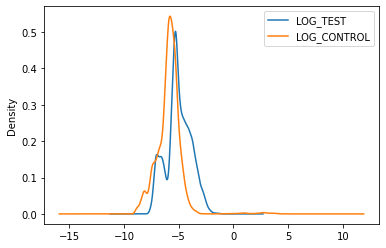

In [ ]:
predf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Kernal Density Post-Treatment

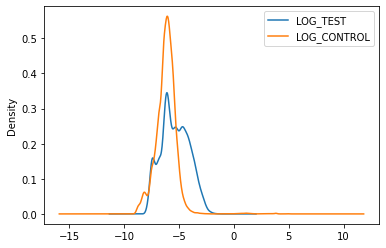

In [ ]:
postdf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Trendline

In [ ]:
fig.show()

### Difference in Difference

log(REL_BID_ASK_SPREAD) = $\beta_{0}$ + $\beta_{1}$dO + $\delta_{0}$dT + $\delta_{1}$dO*dT + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$(dO*dT)|TEST_GROUP:TREATMENT| Difference in Difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.134
Model:                                    OLS   Adj. R-squared:                  0.134
Method:                         Least Squares   F-statistic:                     7717.
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:52:55   Log-Likelihood:            -3.1033e+05
No. Observations:                      199404   AIC:                         6.207e+05
Df Residuals:                          199399   BIC:                         6.207e+05
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.7983      0.007   -849.545      0.000      -5.812      -5.785
TEST_GROUP               0.8664      0.007    119.235      0.000       0.852       0.881
TREATMENT               -0.0749      0.012     -6.509      0.000      -0.097      -0.052
TEST_GROUP:TREATMENT    -0.0528      0.010     -5.141      0.000      -0.073      -0.033
DAY_DELTA               -0.0003   1.22e-05    -23.118      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    53633.806   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           513590.277
Skew:                           1.021   Prob(JB):                         0.00
Kurtosis:                      10.592   Cond. No.                     4.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-5.7983,0.007000,-849.545,0.0,-5.812,-5.785,-579.83
TEST_GROUP,0.8664,0.007000,119.235,0.0,0.852,0.881,86.64
TREATMENT,-0.0749,0.012000,-6.509,0.0,-0.097,-0.052,-7.49
TEST_GROUP:TREATMENT,-0.0528,0.010000,-5.141,0.0,-0.073,-0.033,-5.28
DAY_DELTA,-0.0003,0.000012,-23.118,0.0,-0.000,-0.000,-0.03


### Difference in Difference in Difference- Small Cap

log(REL_BID_ASK_SPREAD) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|SMALLCAP|True if company classified as small
|$\delta_{3}$dO * dS| SMALLCAP:TREATMENT| True if post-treatment and small company
|$\beta_{3}$dO * dS|SMALLCAP:TEST_GROUP| True if company from Norway and classified as small|
|$\delta_{3}$dO * dT * dS|SMALLCAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary2 = results2.summary()
results_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.387
Model:                                    OLS   Adj. R-squared:                  0.387
Method:                         Least Squares   F-statistic:                 1.571e+04
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:52:55   Log-Likelihood:            -2.7593e+05
No. Observations:                      199404   AIC:                         5.519e+05
Df Residuals:                          199395   BIC:                         5.520e+05
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -6.2422      0.007   -836.194      0.000      -6.257      -6.228
TEST_GROUP                        0.4448      0.009     49.082      0.000       0.427       0.463
TREATMENT                         0.1030      0.012      8.728      0.000       0.080       0.126
TEST_GROUP:TREATMENT             -0.2584      0.013    -20.163      0.000      -0.284      -0.233
SMALLCAP                          0.8108      0.009     93.089      0.000       0.794       0.828
SMALLCAP:TREATMENT               -0.3250      0.012    -26.387      0.000      -0.349      -0.301
SMALLCAP:TEST_GROUP               0.7870      0.012     64.087      0.000       0.763       0.811
SMALLCAP:TREATMENT:TEST_GROUP     0.3761      0.017     21.654      0.000       0.342       0.410
DAY_DELTA                        -0.0003   1.03e-05    -27.469      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    98460.010   Durbin-Watson:                   0.287
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2179972.631
Skew:                           1.884   Prob(JB):                         0.00
Kurtosis:                      18.754   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html2 = results_summary2.tables[1].as_html()
dd= pd.read_html(results_as_html2, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-6.2422,0.00700,-836.194,0.0,-6.257,-6.228,-624.22
TEST_GROUP,0.4448,0.00900,49.082,0.0,0.427,0.463,44.48
TREATMENT,0.1030,0.01200,8.728,0.0,0.080,0.126,10.30
TEST_GROUP:TREATMENT,-0.2584,0.01300,-20.163,0.0,-0.284,-0.233,-25.84
SMALLCAP,0.8108,0.00900,93.089,0.0,0.794,0.828,81.08
SMALLCAP:TREATMENT,-0.3250,0.01200,-26.387,0.0,-0.349,-0.301,-32.50
SMALLCAP:TEST_GROUP,0.7870,0.01200,64.087,0.0,0.763,0.811,78.70
SMALLCAP:TREATMENT:TEST_GROUP,0.3761,0.01700,21.654,0.0,0.342,0.410,37.61
DAY_DELTA,-0.0003,0.00001,-27.469,0.0,-0.000,-0.000,-0.03


### Difference in Difference in Difference- Middle Cap

log(REL_BID_ASK_SPREAD) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|MIDCAP|True if company classified as midcap
|$\delta_{3}$dO * dS| MIDAP:TREATMENT| True if post-treatment and a midcap company
|$\beta_{3}$dO * dS|MIDCAP:TEST_GROUP| True if company from Norway and classified as midcap|
|$\delta_{3}$dO * dT * dS|MIDCAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary3=results3.summary()
results_summary3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.215
Model:                                    OLS   Adj. R-squared:                  0.215
Method:                         Least Squares   F-statistic:                     6836.
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:52:55   Log-Likelihood:            -3.0051e+05
No. Observations:                      199404   AIC:                         6.010e+05
Df Residuals:                          199395   BIC:                         6.011e+05
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -5.6791      0.008   -752.922      0.000      -5.694      -5.664
TEST_GROUP                      1.1129      0.009    126.982      0.000       1.096       1.130
TREATMENT                      -0.1687      0.012    -13.804      0.000      -0.193      -0.145
TEST_GROUP:TREATMENT            0.0579      0.012      4.673      0.000       0.034       0.082
MIDCAP                         -0.3145      0.010    -31.115      0.000      -0.334      -0.295
MIDCAP:TREATMENT                0.2476      0.014     17.317      0.000       0.220       0.276
MIDCAP:TEST_GROUP              -0.6606      0.014    -46.277      0.000      -0.689      -0.633
MIDCAP:TREATMENT:TEST_GROUP    -0.2927      0.020    -14.502      0.000      -0.332      -0.253
DAY_DELTA                      -0.0003   1.16e-05    -24.284      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    54978.609   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           838472.445
Skew:                           0.916   Prob(JB):                         0.00
Kurtosis:                      12.877   Cond. No.                     9.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html3 = results_summary3.tables[1].as_html()
dd= pd.read_html(results_as_html3, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-5.6791,0.008000,-752.922,0.0,-5.694,-5.664,-567.91
TEST_GROUP,1.1129,0.009000,126.982,0.0,1.096,1.130,111.29
TREATMENT,-0.1687,0.012000,-13.804,0.0,-0.193,-0.145,-16.87
TEST_GROUP:TREATMENT,0.0579,0.012000,4.673,0.0,0.034,0.082,5.79
MIDCAP,-0.3145,0.010000,-31.115,0.0,-0.334,-0.295,-31.45
MIDCAP:TREATMENT,0.2476,0.014000,17.317,0.0,0.220,0.276,24.76
MIDCAP:TEST_GROUP,-0.6606,0.014000,-46.277,0.0,-0.689,-0.633,-66.06
MIDCAP:TREATMENT:TEST_GROUP,-0.2927,0.020000,-14.502,0.0,-0.332,-0.253,-29.27
DAY_DELTA,-0.0003,0.000012,-24.284,0.0,-0.000,-0.000,-0.03


### Difference in Difference in Difference- Large Cap

log(REL_BID_ASK_SPREAD) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|LARGECAP|True if company classified as large
|$\delta_{3}$dO * dS| LARGECAP:TREATMENT| True if post-treatment and large company
|$\beta_{3}$dO * dS|LARGECAP:TEST_GROUP| True if company from Norway and classified as LARGE|
|$\delta_{3}$dO * dT * dS|LARGECAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary4=results4.summary()
results_summary4

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.323
Model:                                    OLS   Adj. R-squared:                  0.323
Method:                         Least Squares   F-statistic:                 1.188e+04
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:52:56   Log-Likelihood:            -2.8582e+05
No. Observations:                      199404   AIC:                         5.717e+05
Df Residuals:                          199395   BIC:                         5.717e+05
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -5.6614      0.006   -917.396      0.000      -5.673      -5.649
TEST_GROUP                        0.9129      0.007    136.368      0.000       0.900       0.926
TREATMENT                        -0.0989      0.010     -9.570      0.000      -0.119      -0.079
TEST_GROUP:TREATMENT             -0.0265      0.009     -2.802      0.005      -0.045      -0.008
LARGECAP                         -1.8587      0.017   -106.584      0.000      -1.893      -1.824
LARGECAP:TREATMENT                0.3262      0.025     13.228      0.000       0.278       0.375
LARGECAP:TEST_GROUP              -0.3424      0.024    -14.305      0.000      -0.389      -0.296
LARGECAP:TREATMENT:TEST_GROUP    -0.3534      0.034    -10.441      0.000      -0.420      -0.287
DAY_DELTA                        -0.0003   1.08e-05    -26.141      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    84658.319   Durbin-Watson:                   0.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1307985.245
Skew:                           1.636   Prob(JB):                         0.00
Kurtosis:                      15.113   Cond. No.                     1.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html4 = results_summary4.tables[1].as_html()
dd= pd.read_html(results_as_html4, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-5.6614,0.006000,-917.396,0.000,-5.673,-5.649,-566.14
TEST_GROUP,0.9129,0.007000,136.368,0.000,0.900,0.926,91.29
TREATMENT,-0.0989,0.010000,-9.570,0.000,-0.119,-0.079,-9.89
TEST_GROUP:TREATMENT,-0.0265,0.009000,-2.802,0.005,-0.045,-0.008,-2.65
LARGECAP,-1.8587,0.017000,-106.584,0.000,-1.893,-1.824,-185.87
LARGECAP:TREATMENT,0.3262,0.025000,13.228,0.000,0.278,0.375,32.62
LARGECAP:TEST_GROUP,-0.3424,0.024000,-14.305,0.000,-0.389,-0.296,-34.24
LARGECAP:TREATMENT:TEST_GROUP,-0.3534,0.034000,-10.441,0.000,-0.420,-0.287,-35.34
DAY_DELTA,-0.0003,0.000011,-26.141,0.000,-0.000,-0.000,-0.03


In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.134
Model:                                    OLS   Adj. R-squared:                  0.134
Method:                         Least Squares   F-statistic:                     7717.
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:52:56   Log-Likelihood:            -3.1033e+05
No. Observations:                      199404   AIC:                         6.207e+05
Df Residuals:                          199399   BIC:                         6.207e+05
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.7983      0.007   -849.545      0.000      -5.812      -5.785
TEST_GROUP               0.8664      0.007    119.235      0.000       0.852       0.881
TREATMENT               -0.0749      0.012     -6.509      0.000      -0.097      -0.052
TEST_GROUP:TREATMENT    -0.0528      0.010     -5.141      0.000      -0.073      -0.033
DAY_DELTA               -0.0003   1.22e-05    -23.118      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    53633.806   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           513590.277
Skew:                           1.021   Prob(JB):                         0.00
Kurtosis:                      10.592   Cond. No.                     4.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-5.7983,0.007000,-849.545,0.0,-5.812,-5.785,-579.83
TEST_GROUP,0.8664,0.007000,119.235,0.0,0.852,0.881,86.64
TREATMENT,-0.0749,0.012000,-6.509,0.0,-0.097,-0.052,-7.49
TEST_GROUP:TREATMENT,-0.0528,0.010000,-5.141,0.0,-0.073,-0.033,-5.28
DAY_DELTA,-0.0003,0.000012,-23.118,0.0,-0.000,-0.000,-0.03


## Analyst Bid


In [ ]:
results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats = diff_in_diff('TOT_ANALYST_REC')

### Summary Statistics

In [ ]:
predfstats

,CONTROL,TEST
count,50112.000000,50112.000000
mean,8.369752,9.907507
std,6.308952,8.077418
min,1.000000,1.000000
25%,5.000000,4.000000
50%,6.000000,8.000000
75%,9.000000,13.000000
max,35.000000,39.000000


In [ ]:
postdfstats

,CONTROL,TEST
count,50112.000000,50112.000000
mean,8.847462,9.424389
std,6.336430,7.366568
min,1.000000,1.000000
25%,5.000000,4.000000
50%,6.000000,8.000000
75%,10.000000,13.000000
max,38.000000,39.000000


### Kernal Density Pre-Treatment

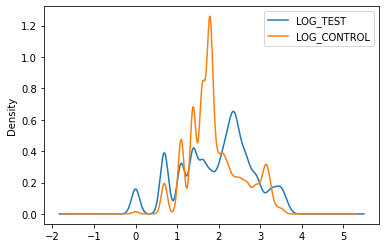

In [ ]:
predf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Kernal Density Post-Treatment

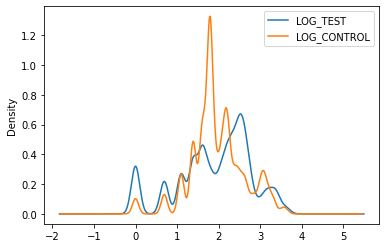

In [ ]:
postdf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Trendline

In [ ]:
fig.show()

### Difference in Difference

log(TOT_ANALYST_REC) = $\beta_{0}$ + $\beta_{1}$dO + $\delta_{0}$dT + $\delta_{1}$dO*dT + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$(dO*dT)|TEST_GROUP:TREATMENT| Difference in Difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(TOT_ANALYST_REC)   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                  0.001
Method:                      Least Squares   F-statistic:                     74.60
Date:                     Thu, 18 Jun 2020   Prob (F-statistic):           2.68e-63
Time:                             16:53:06   Log-Likelihood:            -2.3098e+05
No. Observations:                   200448   AIC:                         4.620e+05
Df Residuals:                       200443   BIC:                         4.620e+05
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.8948      0.005    417.513      0.000       1.886       1.904
TEST_GROUP               0.0565      0.005     11.677      0.000       0.047       0.066
TREATMENT                0.0468      0.008      6.111      0.000       0.032       0.062
TEST_GROUP:TREATMENT    -0.1148      0.007    -16.781      0.000      -0.128      -0.101
DAY_DELTA             2.624e-05   8.11e-06      3.235      0.001    1.03e-05    4.21e-05
==============================================================================
Omnibus:                     2074.177   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2139.238
Skew:                          -0.251   Prob(JB):                         0.00
Kurtosis:                       3.066   Cond. No.                     4.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,1.894800,0.005000,417.513,0.000,1.88600,1.904000,189.480000
TEST_GROUP,0.056500,0.005000,11.677,0.000,0.04700,0.066000,5.650000
TREATMENT,0.046800,0.008000,6.111,0.000,0.03200,0.062000,4.680000
TEST_GROUP:TREATMENT,-0.114800,0.007000,-16.781,0.000,-0.12800,-0.101000,-11.480000
DAY_DELTA,0.000026,0.000008,3.235,0.001,0.00001,0.000042,0.002624


### Difference in Difference in Difference- Small Cap

log(TOT_ANALYST_REC) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|SMALLCAP|True if company classified as small
|$\delta_{3}$dO * dS| SMALLCAP:TREATMENT| True if post-treatment and small company
|$\beta_{3}$dO * dS|SMALLCAP:TEST_GROUP| True if company from Norway and classified as small|
|$\delta_{3}$dO * dT * dS|SMALLCAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary2 = results2.summary()
results_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(TOT_ANALYST_REC)   R-squared:                       0.318
Model:                                 OLS   Adj. R-squared:                  0.318
Method:                      Least Squares   F-statistic:                 1.169e+04
Date:                     Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                             16:53:06   Log-Likelihood:            -1.9275e+05
No. Observations:                   200448   AIC:                         3.855e+05
Df Residuals:                       200439   BIC:                         3.856e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.1833      0.005    450.250      0.000       2.174       2.193
TEST_GROUP                        0.3896      0.006     65.961      0.000       0.378       0.401
TREATMENT                         0.0026      0.008      0.341      0.733      -0.012       0.018
TEST_GROUP:TREATMENT             -0.1007      0.008    -12.059      0.000      -0.117      -0.084
SMALLCAP                         -0.5327      0.006    -93.870      0.000      -0.544      -0.522
SMALLCAP:TREATMENT                0.0815      0.008     10.160      0.000       0.066       0.097
SMALLCAP:TEST_GROUP              -0.6150      0.008    -76.625      0.000      -0.631      -0.599
SMALLCAP:TREATMENT:TEST_GROUP    -0.0260      0.011     -2.294      0.022      -0.048      -0.004
DAY_DELTA                      2.624e-05    6.7e-06      3.915      0.000    1.31e-05    3.94e-05
==============================================================================
Omnibus:                     3999.125   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4242.199
Skew:                          -0.355   Prob(JB):                         0.00
Kurtosis:                       3.055   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html2 = results_summary2.tables[1].as_html()
dd= pd.read_html(results_as_html2, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,2.183300,0.005000,450.250,0.000,2.174000,2.193000,218.330000
TEST_GROUP,0.389600,0.006000,65.961,0.000,0.378000,0.401000,38.960000
TREATMENT,0.002600,0.008000,0.341,0.733,-0.012000,0.018000,0.260000
TEST_GROUP:TREATMENT,-0.100700,0.008000,-12.059,0.000,-0.117000,-0.084000,-10.070000
SMALLCAP,-0.532700,0.006000,-93.870,0.000,-0.544000,-0.522000,-53.270000
SMALLCAP:TREATMENT,0.081500,0.008000,10.160,0.000,0.066000,0.097000,8.150000
SMALLCAP:TEST_GROUP,-0.615000,0.008000,-76.625,0.000,-0.631000,-0.599000,-61.500000
SMALLCAP:TREATMENT:TEST_GROUP,-0.026000,0.011000,-2.294,0.022,-0.048000,-0.004000,-2.600000
DAY_DELTA,0.000026,0.000007,3.915,0.000,0.000013,0.000039,0.002624


### Difference in Difference in Difference- Middle Cap

log(TOT_ANALYST_REC) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|MIDCAP|True if company classified as midcap
|$\delta_{3}$dO * dS| MIDAP:TREATMENT| True if post-treatment and a midcap company
|$\beta_{3}$dO * dS|MIDCAP:TEST_GROUP| True if company from Norway and classified as midcap|
|$\delta_{3}$dO * dT * dS|MIDCAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary3=results3.summary()
results_summary3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(TOT_ANALYST_REC)   R-squared:                       0.120
Model:                                 OLS   Adj. R-squared:                  0.119
Method:                      Least Squares   F-statistic:                     3401.
Date:                     Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                             16:53:07   Log-Likelihood:            -2.1837e+05
No. Observations:                   200448   AIC:                         4.368e+05
Df Residuals:                       200439   BIC:                         4.368e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.8299      0.005    370.778      0.000       1.820       1.840
TEST_GROUP                     -0.1692      0.006    -29.444      0.000      -0.181      -0.158
TREATMENT                       0.0707      0.008      8.832      0.000       0.055       0.086
TEST_GROUP:TREATMENT           -0.1239      0.008    -15.237      0.000      -0.140      -0.108
MIDCAP                          0.1731      0.007     26.085      0.000       0.160       0.186
MIDCAP:TREATMENT               -0.0638      0.009     -6.794      0.000      -0.082      -0.045
MIDCAP:TEST_GROUP               0.6020      0.009     64.135      0.000       0.584       0.620
MIDCAP:TREATMENT:TEST_GROUP     0.0240      0.013      1.812      0.070      -0.002       0.050
DAY_DELTA                    2.624e-05   7.62e-06      3.445      0.001    1.13e-05    4.12e-05
==============================================================================
Omnibus:                      780.470   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1007.629
Skew:                           0.060   Prob(JB):                    1.57e-219
Kurtosis:                       3.326   Cond. No.                     9.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html3 = results_summary3.tables[1].as_html()
dd= pd.read_html(results_as_html3, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,1.829900,0.005000,370.778,0.000,1.820000,1.840000,182.990000
TEST_GROUP,-0.169200,0.006000,-29.444,0.000,-0.181000,-0.158000,-16.920000
TREATMENT,0.070700,0.008000,8.832,0.000,0.055000,0.086000,7.070000
TEST_GROUP:TREATMENT,-0.123900,0.008000,-15.237,0.000,-0.140000,-0.108000,-12.390000
MIDCAP,0.173100,0.007000,26.085,0.000,0.160000,0.186000,17.310000
MIDCAP:TREATMENT,-0.063800,0.009000,-6.794,0.000,-0.082000,-0.045000,-6.380000
MIDCAP:TEST_GROUP,0.602000,0.009000,64.135,0.000,0.584000,0.620000,60.200000
MIDCAP:TREATMENT:TEST_GROUP,0.024000,0.013000,1.812,0.070,-0.002000,0.050000,2.400000
DAY_DELTA,0.000026,0.000008,3.445,0.001,0.000011,0.000041,0.002624


### Difference in Difference in Difference- Large Cap

log(TOT_ANALYST_REC) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|LARGECAP|True if company classified as large
|$\delta_{3}$dO * dS| LARGECAP:TREATMENT| True if post-treatment and large company
|$\beta_{3}$dO * dS|LARGECAP:TEST_GROUP| True if company from Norway and classified as LARGE|
|$\delta_{3}$dO * dT * dS|LARGECAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary4=results4.summary()
results_summary4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(TOT_ANALYST_REC)   R-squared:                       0.204
Model:                                 OLS   Adj. R-squared:                  0.204
Method:                      Least Squares   F-statistic:                     6406.
Date:                     Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                             16:53:07   Log-Likelihood:            -2.0831e+05
No. Observations:                   200448   AIC:                         4.166e+05
Df Residuals:                       200439   BIC:                         4.167e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.7948      0.004    431.807      0.000       1.787       1.803
TEST_GROUP                        0.0439      0.005      9.718      0.000       0.035       0.053
TREATMENT                         0.0526      0.007      7.552      0.000       0.039       0.066
TEST_GROUP:TREATMENT             -0.1157      0.006    -18.131      0.000      -0.128      -0.103
LARGECAP                          1.2001      0.011    108.547      0.000       1.178       1.222
LARGECAP:TREATMENT               -0.0694      0.016     -4.436      0.000      -0.100      -0.039
LARGECAP:TEST_GROUP               0.1517      0.016      9.700      0.000       0.121       0.182
LARGECAP:TREATMENT:TEST_GROUP     0.0108      0.022      0.490      0.624      -0.033       0.054
DAY_DELTA                      2.624e-05   7.24e-06      3.622      0.000     1.2e-05    4.04e-05
==============================================================================
Omnibus:                     5650.967   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6777.253
Skew:                          -0.364   Prob(JB):                         0.00
Kurtosis:                       3.531   Cond. No.                     1.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html4 = results_summary4.tables[1].as_html()
dd= pd.read_html(results_as_html4, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,1.794800,0.004000,431.807,0.000,1.787000,1.80300,179.480000
TEST_GROUP,0.043900,0.005000,9.718,0.000,0.035000,0.05300,4.390000
TREATMENT,0.052600,0.007000,7.552,0.000,0.039000,0.06600,5.260000
TEST_GROUP:TREATMENT,-0.115700,0.006000,-18.131,0.000,-0.128000,-0.10300,-11.570000
LARGECAP,1.200100,0.011000,108.547,0.000,1.178000,1.22200,120.010000
LARGECAP:TREATMENT,-0.069400,0.016000,-4.436,0.000,-0.100000,-0.03900,-6.940000
LARGECAP:TEST_GROUP,0.151700,0.016000,9.700,0.000,0.121000,0.18200,15.170000
LARGECAP:TREATMENT:TEST_GROUP,0.010800,0.022000,0.490,0.624,-0.033000,0.05400,1.080000
DAY_DELTA,0.000026,0.000007,3.622,0.000,0.000012,0.00004,0.002624


## Liquidity Ratio- 3

In [ ]:
results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats = diff_in_diff('LQ3')

### Summary Statistics

In [ ]:
predfstats

,CONTROL,TEST
count,50112.000000,50112.000000
mean,0.000136,0.000449
std,0.001511,0.203423
min,-0.028536,-13.610439
25%,-0.000239,-0.001756
50%,0.000112,0.000100
75%,0.000522,0.001975
max,0.025239,9.073793


In [ ]:
postdfstats

,CONTROL,TEST
count,50112.000000,50112.000000
mean,0.000131,0.000635
std,0.002072,0.077414
min,-0.044515,-2.999600
25%,-0.000272,-0.001329
50%,0.000119,0.000100
75%,0.000562,0.001437
max,0.036767,2.999800


### Kernal Density Pre-Treatment

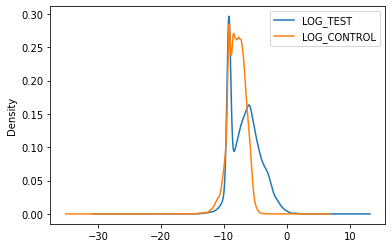

In [ ]:
predf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()


### Kernal Density Post-Treatment

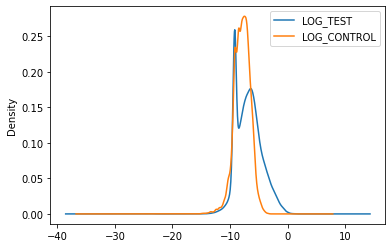

In [ ]:
postdf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Trendline

In [ ]:
fig.show()

### Difference in Difference

log(LQ3) = $\beta_{0}$ + $\beta_{1}$dO + $\delta_{0}$dT + $\delta_{1}$dO*dT + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$(dO*dT)|TEST_GROUP:TREATMENT| Difference in Difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(LQ3)   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3480.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:13   Log-Likelihood:            -2.4514e+05
No. Observations:              120630   AIC:                         4.903e+05
Df Residuals:                  120625   BIC:                         4.903e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -7.9257      0.014   -572.148      0.000      -7.953      -7.899
TEST_GROUP               1.3722      0.015     91.592      0.000       1.343       1.402
TREATMENT                0.1764      0.024      7.447      0.000       0.130       0.223
TEST_GROUP:TREATMENT    -0.2503      0.021    -11.755      0.000      -0.292      -0.209
DAY_DELTA               -0.0001   2.52e-05     -5.058      0.000      -0.000    -7.8e-05
==============================================================================
Omnibus:                     3714.654   Durbin-Watson:                   1.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8412.843
Skew:                           0.169   Prob(JB):                         0.00
Kurtosis:                       4.249   Cond. No.                     4.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-7.9257,0.014000,-572.148,0.0,-7.953,-7.899000,-792.57
TEST_GROUP,1.3722,0.015000,91.592,0.0,1.343,1.402000,137.22
TREATMENT,0.1764,0.024000,7.447,0.0,0.130,0.223000,17.64
TEST_GROUP:TREATMENT,-0.2503,0.021000,-11.755,0.0,-0.292,-0.209000,-25.03
DAY_DELTA,-0.0001,0.000025,-5.058,0.0,-0.000,-0.000078,-0.01


### Difference in Difference in Difference- Small Cap

log(LQ3) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|SMALLCAP|True if company classified as small
|$\delta_{3}$dO * dS| SMALLCAP:TREATMENT| True if post-treatment and small company
|$\beta_{3}$dO * dS|SMALLCAP:TEST_GROUP| True if company from Norway and classified as small|
|$\delta_{3}$dO * dT * dS|SMALLCAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary2 = results2.summary()
results_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(LQ3)   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     2412.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:13   Log-Likelihood:            -2.4278e+05
No. Observations:              120630   AIC:                         4.856e+05
Df Residuals:                  120621   BIC:                         4.857e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.0832      0.017   -471.700      0.000      -8.117      -8.050
TEST_GROUP                        0.9219      0.021     43.020      0.000       0.880       0.964
TREATMENT                         0.2944      0.028     10.629      0.000       0.240       0.349
TEST_GROUP:TREATMENT             -0.2641      0.031     -8.639      0.000      -0.324      -0.204
SMALLCAP                          0.3038      0.020     14.963      0.000       0.264       0.344
SMALLCAP:TREATMENT               -0.2323      0.029     -8.052      0.000      -0.289      -0.176
SMALLCAP:TEST_GROUP               0.8174      0.029     27.763      0.000       0.760       0.875
SMALLCAP:TREATMENT:TEST_GROUP     0.0315      0.042      0.752      0.452      -0.051       0.114
DAY_DELTA                        -0.0001   2.47e-05     -5.096      0.000      -0.000   -7.75e-05
==============================================================================
Omnibus:                     2947.943   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7028.833
Skew:                          -0.037   Prob(JB):                         0.00
Kurtosis:                       4.180   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html2 = results_summary2.tables[1].as_html()
dd= pd.read_html(results_as_html2, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-8.0832,0.017000,-471.700,0.000,-8.117,-8.050000,-808.32
TEST_GROUP,0.9219,0.021000,43.020,0.000,0.880,0.964000,92.19
TREATMENT,0.2944,0.028000,10.629,0.000,0.240,0.349000,29.44
TEST_GROUP:TREATMENT,-0.2641,0.031000,-8.639,0.000,-0.324,-0.204000,-26.41
SMALLCAP,0.3038,0.020000,14.963,0.000,0.264,0.344000,30.38
SMALLCAP:TREATMENT,-0.2323,0.029000,-8.052,0.000,-0.289,-0.176000,-23.23
SMALLCAP:TEST_GROUP,0.8174,0.029000,27.763,0.000,0.760,0.875000,81.74
SMALLCAP:TREATMENT:TEST_GROUP,0.0315,0.042000,0.752,0.452,-0.051,0.114000,3.15
DAY_DELTA,-0.0001,0.000025,-5.096,0.000,-0.000,-0.000077,-0.01


### Difference in Difference in Difference- Middle Cap

log(LQ3) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|MIDCAP|True if company classified as midcap
|$\delta_{3}$dO * dS| MIDAP:TREATMENT| True if post-treatment and a midcap company
|$\beta_{3}$dO * dS|MIDCAP:TEST_GROUP| True if company from Norway and classified as midcap|
|$\delta_{3}$dO * dT * dS|MIDCAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary3=results3.summary()
results_summary3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(LQ3)   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1913.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:14   Log-Likelihood:            -2.4453e+05
No. Observations:              120630   AIC:                         4.891e+05
Df Residuals:                  120621   BIC:                         4.892e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -7.9398      0.016   -497.810      0.000      -7.971      -7.909
TEST_GROUP                      1.6041      0.019     85.252      0.000       1.567       1.641
TREATMENT                       0.1094      0.026      4.192      0.000       0.058       0.161
TEST_GROUP:TREATMENT           -0.2306      0.027     -8.639      0.000      -0.283      -0.178
MIDCAP                          0.0353      0.021      1.661      0.097      -0.006       0.077
MIDCAP:TREATMENT                0.1768      0.030      5.850      0.000       0.118       0.236
MIDCAP:TEST_GROUP              -0.6274      0.031    -20.349      0.000      -0.688      -0.567
MIDCAP:TREATMENT:TEST_GROUP    -0.0581      0.044     -1.325      0.185      -0.144       0.028
DAY_DELTA                      -0.0001   2.51e-05     -4.996      0.000      -0.000   -7.61e-05
==============================================================================
Omnibus:                     2949.468   Durbin-Watson:                   1.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6801.869
Skew:                           0.077   Prob(JB):                         0.00
Kurtosis:                       4.153   Cond. No.                     9.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html3 = results_summary3.tables[1].as_html()
dd= pd.read_html(results_as_html3, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-7.9398,0.016000,-497.810,0.000,-7.971,-7.909000,-793.98
TEST_GROUP,1.6041,0.019000,85.252,0.000,1.567,1.641000,160.41
TREATMENT,0.1094,0.026000,4.192,0.000,0.058,0.161000,10.94
TEST_GROUP:TREATMENT,-0.2306,0.027000,-8.639,0.000,-0.283,-0.178000,-23.06
MIDCAP,0.0353,0.021000,1.661,0.097,-0.006,0.077000,3.53
MIDCAP:TREATMENT,0.1768,0.030000,5.850,0.000,0.118,0.236000,17.68
MIDCAP:TEST_GROUP,-0.6274,0.031000,-20.349,0.000,-0.688,-0.567000,-62.74
MIDCAP:TREATMENT:TEST_GROUP,-0.0581,0.044000,-1.325,0.185,-0.144,0.028000,-5.81
DAY_DELTA,-0.0001,0.000025,-4.996,0.000,-0.000,-0.000076,-0.01


### Difference in Difference in Difference- Large Cap

log(LQ3) = $\beta_{0}$ + $\beta_{1}$dO +$\beta_{2}$dS + $\beta_{3}$dO * dS + $\delta_{0}$dT + $\delta_{1}$dO * dT + $\delta_{2}$dO * dS + $\delta_{3}$dO * dT * dS + $\Delta_{0}$Day


|Eq Variable| Code Variable| Description|
|---|---|---|
|$\beta_{0}$|Intercept|Intercept Term|
|$\beta_{1}$dO|TEST_GROUP|True if Norway Company|
|$\delta_{0}$dT|TREATMENT|True if Post 2018-01-03|
|$\delta_{1}$dO * dT|TEST_GROUP:TREATMENT| Difference in Difference|
|$\beta_{3}$dS|LARGECAP|True if company classified as large
|$\delta_{3}$dO * dS| LARGECAP:TREATMENT| True if post-treatment and large company
|$\beta_{3}$dO * dS|LARGECAP:TEST_GROUP| True if company from Norway and classified as LARGE|
|$\delta_{3}$dO * dT * dS|LARGECAP:TREATMENT:TEST_GROUP|Difference in difference in difference|
|$\Delta_{0}$Day|DAY_DELTA|Days since start of testing period|

In [ ]:
results_summary4=results4.summary()
results_summary4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(LQ3)   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     2415.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:14   Log-Likelihood:            -2.4277e+05
No. Observations:              120630   AIC:                         4.856e+05
Df Residuals:                  120621   BIC:                         4.856e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -7.8308      0.014   -558.025      0.000      -7.858      -7.803
TEST_GROUP                        1.4321      0.015     92.594      0.000       1.402       1.462
TREATMENT                         0.1582      0.024      6.664      0.000       0.112       0.205
TEST_GROUP:TREATMENT             -0.2551      0.022    -11.614      0.000      -0.298      -0.212
LARGECAP                         -0.8773      0.033    -26.784      0.000      -0.942      -0.813
LARGECAP:TREATMENT                0.1376      0.047      2.918      0.004       0.045       0.230
LARGECAP:TEST_GROUP              -0.8533      0.050    -17.190      0.000      -0.951      -0.756
LARGECAP:TREATMENT:TEST_GROUP     0.1342      0.071      1.891      0.059      -0.005       0.273
DAY_DELTA                        -0.0001   2.47e-05     -5.227      0.000      -0.000   -8.07e-05
==============================================================================
Omnibus:                     3650.471   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9542.604
Skew:                           0.072   Prob(JB):                         0.00
Kurtosis:                       4.370   Cond. No.                     1.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html4 = results_summary4.tables[1].as_html()
dd= pd.read_html(results_as_html4, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-7.8308,0.014000,-558.025,0.000,-7.858,-7.803000,-783.08
TEST_GROUP,1.4321,0.015000,92.594,0.000,1.402,1.462000,143.21
TREATMENT,0.1582,0.024000,6.664,0.000,0.112,0.205000,15.82
TEST_GROUP:TREATMENT,-0.2551,0.022000,-11.614,0.000,-0.298,-0.212000,-25.51
LARGECAP,-0.8773,0.033000,-26.784,0.000,-0.942,-0.813000,-87.73
LARGECAP:TREATMENT,0.1376,0.047000,2.918,0.004,0.045,0.230000,13.76
LARGECAP:TEST_GROUP,-0.8533,0.050000,-17.190,0.000,-0.951,-0.756000,-85.33
LARGECAP:TREATMENT:TEST_GROUP,0.1342,0.071000,1.891,0.059,-0.005,0.273000,13.42
DAY_DELTA,-0.0001,0.000025,-5.227,0.000,-0.000,-0.000081,-0.01


# One Year Pre/Post

## Setting up Difference in Difference 2 

In [ ]:
testing=False
del df

In [ ]:

# Calling the 2nd data set with the caluculate LQ3 and reformatting it 
#just like the first dataset
df= pd.read_csv('drive/My Drive/FinalData.csv', mangle_dupe_cols=True, header = [0,1])
columns = pd.DataFrame(df.columns.tolist())
columns.loc[columns[0].str.startswith('Unnamed:'), 0] = np.nan
columns[0] = columns[0].fillna(method='ffill')
mask = pd.isnull(columns[0])
columns[0] = columns[0].fillna('')
columns.loc[mask, [0,1]] = columns.loc[mask, [1,0]].values
df.columns = pd.MultiIndex.from_tuples(columns.to_records(index=False).tolist())
df = df.loc[:,~df.columns.duplicated()]
df['Dates']= [parse(i).date() for i in df['Dates']]
for i in df.columns:
  if i[1]== 'CHG_NET_1D':
    df[i[0],'LQ3']=df[i[0], 'CHG_NET_1D']/(df[i[0], 'VWAP_NUM_TRADES']+.0001)
    df[i[0],'LQ3']=df[i[0],'LQ3'].fillna(0.0001)
    df[i[0],'LQ3']=df[i[0],'LQ3']+.0001
    df[i[0],'REL_BID_ASK_SPREAD']=df[i[0], 'AVERAGE_BID_ASK_SPREAD']/df[i[0], 'PX_LAST']

In [ ]:
from statsmodels.formula.api import ols
import numpy as np
# This tries to fix the excel file
def clear_error(a):
    if a == '#NAME?':
      return float(0)
    else:
      return float(a)

def diff_in_diff(KeyColumn): # This is the regression
  try:
    del turnover
    del turnover1
    del temp
  except:
    pass
  for index, row in matchlist2.iterrows():
    i=row[0]
    j=row[1]
    # the loops tries to go through dates, this skips it
    if j == 'Dates':
      continue
    if i in ['Dates']:
      continue
    try:
      # This is the operations for all but the first match
      temp=pd.DataFrame(df[i][KeyColumn])
      temp['Date']=df['Dates']
      temp['TEST_GROUP']=1
      temp['SMALLCAP']=row['SMALLCAP']
      temp['MIDCAP']=row['MIDCAP']
      temp['LARGECAP']=row['LARGECAP']
      turnover=pd.concat([turnover,temp])
    except:
      # this is the first match operation
      turnover=df[i][KeyColumn]
      turnover=pd.DataFrame(turnover)
      turnover['Date']=df['Dates']
      turnover['TEST_GROUP']=1
      turnover['SMALLCAP']=row['SMALLCAP']
      turnover['MIDCAP']=row['MIDCAP']
      turnover['LARGECAP']=row['LARGECAP']
    temp2=pd.DataFrame(df[j][KeyColumn])
    temp2['Date']= df['Dates']
    temp2['SMALLCAP']=row['SMALLCAP']
    temp2['MIDCAP']=row['MIDCAP']
    temp2['LARGECAP']=row['LARGECAP']
    temp2['TEST_GROUP']=0
    turnover=pd.concat([turnover, temp2])
  # increases the value of the total analyst rec by 1 in order to make logistic regression possible 
  if KeyColumn == 'TOT_ANALYST_REC':
    turnover[KeyColumn]=turnover[KeyColumn]+1
  # manipulates the value of LQ3 so that it can use logistic regression
  # if KeyColumn == 'LQ3':
  #   turnover[KeyColumn]=turnover[KeyColumn]*10+1
  turnover['Date']= pd.to_datetime(turnover['Date'])
  start_date='2017-01-03'; end_date='2019-01-03'
  turnover['TREATMENT'] = np.where((turnover['Date'] > '2018-01-03'), 1, 0)
  mask = (turnover['Date'] > start_date) & (turnover['Date'] <= end_date)
  turnover=turnover.loc[mask]
  turnover['DAY_DELTA'] = (turnover.Date - turnover.Date.min()).dt.days
  turnover['DID']=turnover['TEST_GROUP']*turnover['TREATMENT']
  turnover['SMALLORMID']=turnover['SMALLCAP']+turnover['MIDCAP']
  turnover[KeyColumn]=turnover[KeyColumn].apply(clear_error)
  if testing:
    print(turnover)
  

  stringmethod='np.log('+KeyColumn + ") ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + DAY_DELTA"
  stringmethod2='np.log('+KeyColumn + ") ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + SMALLCAP + SMALLCAP * TREATMENT + SMALLCAP * TEST_GROUP + SMALLCAP * TREATMENT * TEST_GROUP + DAY_DELTA"
  stringmethod3='np.log('+KeyColumn + ") ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + MIDCAP + MIDCAP * TREATMENT + MIDCAP * TEST_GROUP + MIDCAP * TREATMENT * TEST_GROUP + DAY_DELTA"
  stringmethod4='np.log('+KeyColumn + ") ~ TEST_GROUP + TREATMENT + TEST_GROUP * TREATMENT + LARGECAP + LARGECAP * TREATMENT + LARGECAP * TEST_GROUP + LARGECAP * TREATMENT * TEST_GROUP + DAY_DELTA"
  model = ols(stringmethod, data=turnover)
  model2 = ols(stringmethod2, data=turnover)
  model3 = ols(stringmethod3, data=turnover)
  model4 = ols(stringmethod4, data=turnover)
  
  keydf= turnover[[KeyColumn, 'TEST_GROUP', 'TREATMENT', 'Date']]
  dfcontrol=keydf.loc[keydf['TEST_GROUP']==0];dftest=keydf.loc[keydf['TEST_GROUP']==1]
  masterdf=dfcontrol
  masterdf['CONTROL']=masterdf[KeyColumn]
  masterdf['TEST']=dftest[KeyColumn]
  masterdf['LOG_CONTROL']=np.log(masterdf['CONTROL'])
  masterdf['LOG_TEST']=np.log(masterdf['TEST'])
  predf=masterdf.loc[masterdf['TREATMENT']==0]
  postdf=masterdf.loc[masterdf['TREATMENT']==1]
  results = model.fit()
  results2 = model2.fit()
  results3 = model3.fit()
  results4 = model4.fit()
  aggregatedf=masterdf.groupby(['Date']).mean()
  aggregatedf=aggregatedf.drop(['TEST_GROUP', KeyColumn], axis=1)
  aggregatedf=aggregatedf.rolling(30).mean()
  aggregatedf=aggregatedf.reset_index()
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=aggregatedf['Date'], y=aggregatedf['LOG_TEST'], name='OSLO_'+KeyColumn,
                         line=dict(color='firebrick', width=4)))
  fig.add_trace(go.Scatter(x=aggregatedf['Date'], y=aggregatedf['LOG_CONTROL'], name='US_'+KeyColumn,
                         line=dict(color='royalblue', width=4)))
  
  mini=aggregatedf['LOG_CONTROL'].min()if aggregatedf['LOG_CONTROL'].min()< aggregatedf['LOG_TEST'].min() else aggregatedf['LOG_TEST'].min()
  maxi=aggregatedf['LOG_CONTROL'].max()if aggregatedf['LOG_CONTROL'].max()> aggregatedf['LOG_TEST'].max() else aggregatedf['LOG_TEST'].max()
  fig.add_shape(
          # Line Vertical
          dict(
              type="line",
              x0='2018-01-03',
              y0=mini,
              x1='2018-01-03',
              y1=maxi,
              line=dict(
                  color="Black",
                  width=3 )
  ))
  predfstats = predf[['CONTROL', 'TEST']].describe()
  postdfstats= postdf[['CONTROL', 'TEST']].describe()
  del turnover
  del temp
  return results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats

In [ ]:
# Tool to get the tables
def strtotable(strish):
  strish=strish.replace('\t', ' | ')
  strish='''|Variable | coef |	std err |	t |	P-value |	0.025 |	0.975 |
|---|---|---|---|---|---|---|'''+'\n'+strish+'\n'+'Significant at $\alpha$=0.001***|'
  return(strish)


## Turnover

In [ ]:
testing=False
results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats= diff_in_diff('TURNOVER')

### Summary Statistics

In [ ]:
predfstats

,CONTROL,TEST
count,2.479500e+04,2.505600e+04
mean,2.515773e+07,3.643585e+07
std,6.206007e+07,9.614981e+07
min,7.912714e+04,3.570000e+00
25%,1.628064e+06,6.238337e+05
50%,4.441557e+06,4.110778e+06
75%,1.702480e+07,2.021769e+07
max,1.782052e+09,4.265468e+09


In [ ]:
postdfstats

,CONTROL,TEST
count,2.479500e+04,2.505600e+04
mean,3.204314e+07,4.654740e+07
std,8.284910e+07,1.187995e+08
min,9.961104e+04,8.160000e+00
25%,2.568472e+06,6.773326e+05
50%,5.381038e+06,5.887558e+06
75%,1.858132e+07,3.238235e+07
max,4.367208e+09,4.559098e+09


### Kernal Density Pre-Treatment

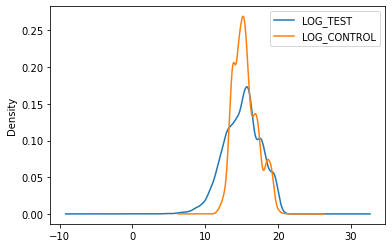

In [ ]:
predf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Kernal Density Post-Treatment

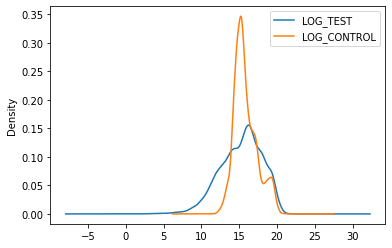

In [ ]:
postdf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Trendline

In [ ]:
fig.show()

### Difference in Difference

In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(TURNOVER)   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     430.5
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:36   Log-Likelihood:            -2.1947e+05
No. Observations:               99702   AIC:                         4.390e+05
Df Residuals:                   99697   BIC:                         4.390e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               15.4961      0.018    846.078      0.000      15.460      15.532
TEST_GROUP              -0.4598      0.020    -23.476      0.000      -0.498      -0.421
TREATMENT                0.2094      0.031      6.728      0.000       0.148       0.270
TEST_GROUP:TREATMENT    -0.1091      0.028     -3.940      0.000      -0.163      -0.055
DAY_DELTA                0.0002   6.59e-05      3.752      0.000       0.000       0.000
==============================================================================
Omnibus:                     2193.928   Durbin-Watson:                   0.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3203.407
Skew:                          -0.247   Prob(JB):                         0.00
Kurtosis:                       3.726   Cond. No.                     2.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.4961,0.018000,846.078,0.0,15.460,15.532
TEST_GROUP,-0.4598,0.020000,-23.476,0.0,-0.498,-0.421
TREATMENT,0.2094,0.031000,6.728,0.0,0.148,0.270
TEST_GROUP:TREATMENT,-0.1091,0.028000,-3.940,0.0,-0.163,-0.055
DAY_DELTA,0.0002,0.000066,3.752,0.0,0.000,0.000


### Difference in Difference in Difference- Small Cap

In [ ]:
results_summary2 = results2.summary()
results_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(TURNOVER)   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     8135.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:36   Log-Likelihood:            -1.9528e+05
No. Observations:               99702   AIC:                         3.906e+05
Df Residuals:                   99693   BIC:                         3.907e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        16.5919      0.019    886.856      0.000      16.555      16.629
TEST_GROUP                        0.2116      0.023      9.291      0.000       0.167       0.256
TREATMENT                         0.0817      0.030      2.749      0.006       0.023       0.140
TEST_GROUP:TREATMENT              0.1102      0.032      3.422      0.001       0.047       0.173
SMALLCAP                         -2.0018      0.022    -91.459      0.000      -2.045      -1.959
SMALLCAP:TREATMENT                0.2332      0.031      7.534      0.000       0.173       0.294
SMALLCAP:TEST_GROUP              -1.2605      0.031    -40.850      0.000      -1.321      -1.200
SMALLCAP:TREATMENT:TEST_GROUP    -0.4024      0.044     -9.222      0.000      -0.488      -0.317
DAY_DELTA                         0.0002   5.17e-05      4.782      0.000       0.000       0.000
==============================================================================
Omnibus:                     3849.560   Durbin-Watson:                   0.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7114.786
Skew:                          -0.308   Prob(JB):                         0.00
Kurtosis:                       4.155   Cond. No.                     5.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html2 = results_summary2.tables[1].as_html()
dd= pd.read_html(results_as_html2, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,16.5919,0.019000,886.856,0.000,16.555,16.629,1659.19
TEST_GROUP,0.2116,0.023000,9.291,0.000,0.167,0.256,21.16
TREATMENT,0.0817,0.030000,2.749,0.006,0.023,0.140,8.17
TEST_GROUP:TREATMENT,0.1102,0.032000,3.422,0.001,0.047,0.173,11.02
SMALLCAP,-2.0018,0.022000,-91.459,0.000,-2.045,-1.959,-200.18
SMALLCAP:TREATMENT,0.2332,0.031000,7.534,0.000,0.173,0.294,23.32
SMALLCAP:TEST_GROUP,-1.2605,0.031000,-40.850,0.000,-1.321,-1.200,-126.05
SMALLCAP:TREATMENT:TEST_GROUP,-0.4024,0.044000,-9.222,0.000,-0.488,-0.317,-40.24
DAY_DELTA,0.0002,0.000052,4.782,0.000,0.000,0.000,0.02


### Difference in Difference in Difference- Middle Cap

In [ ]:
results_summary3=results3.summary()
results_summary3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(TURNOVER)   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2226.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:36   Log-Likelihood:            -2.1213e+05
No. Observations:               99702   AIC:                         4.243e+05
Df Residuals:                   99693   BIC:                         4.244e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      15.0577      0.020    761.394      0.000      15.019      15.096
TEST_GROUP                     -0.7720      0.023    -33.482      0.000      -0.817      -0.727
TREATMENT                       0.2986      0.032      9.265      0.000       0.235       0.362
TEST_GROUP:TREATMENT           -0.2805      0.033     -8.604      0.000      -0.344      -0.217
MIDCAP                          1.1570      0.027     43.505      0.000       1.105       1.209
MIDCAP:TREATMENT               -0.2356      0.038     -6.265      0.000      -0.309      -0.162
MIDCAP:TEST_GROUP               0.8445      0.038     22.490      0.000       0.771       0.918
MIDCAP:TREATMENT:TEST_GROUP     0.4546      0.053      8.561      0.000       0.351       0.559
DAY_DELTA                       0.0002   6.12e-05      4.038      0.000       0.000       0.000
==============================================================================
Omnibus:                     3391.638   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7760.897
Skew:                           0.196   Prob(JB):                         0.00
Kurtosis:                       4.310   Cond. No.                     4.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html3 = results_summary3.tables[1].as_html()
dd= pd.read_html(results_as_html3, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,15.0577,0.020000,761.394,0.0,15.019,15.096,1505.77
TEST_GROUP,-0.7720,0.023000,-33.482,0.0,-0.817,-0.727,-77.20
TREATMENT,0.2986,0.032000,9.265,0.0,0.235,0.362,29.86
TEST_GROUP:TREATMENT,-0.2805,0.033000,-8.604,0.0,-0.344,-0.217,-28.05
MIDCAP,1.1570,0.027000,43.505,0.0,1.105,1.209,115.70
MIDCAP:TREATMENT,-0.2356,0.038000,-6.265,0.0,-0.309,-0.162,-23.56
MIDCAP:TEST_GROUP,0.8445,0.038000,22.490,0.0,0.771,0.918,84.45
MIDCAP:TREATMENT:TEST_GROUP,0.4546,0.053000,8.561,0.0,0.351,0.559,45.46
DAY_DELTA,0.0002,0.000061,4.038,0.0,0.000,0.000,0.02


### Difference in Difference in Difference- Large Cap

In [ ]:
results_summary4=results4.summary()
results_summary4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(TURNOVER)   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     4024.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:36   Log-Likelihood:            -2.0638e+05
No. Observations:               99702   AIC:                         4.128e+05
Df Residuals:                   99693   BIC:                         4.129e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        15.2547      0.016    928.778      0.000      15.222      15.287
TEST_GROUP                       -0.5902      0.018    -32.982      0.000      -0.625      -0.555
TREATMENT                         0.2119      0.028      7.644      0.000       0.158       0.266
TEST_GROUP:TREATMENT             -0.1015      0.025     -4.010      0.000      -0.151      -0.052
LARGECAP                          3.2770      0.047     70.305      0.000       3.186       3.368
LARGECAP:TREATMENT               -0.0341      0.066     -0.518      0.605      -0.163       0.095
LARGECAP:TEST_GROUP               1.1847      0.064     18.515      0.000       1.059       1.310
LARGECAP:TREATMENT:TEST_GROUP    -0.0878      0.090     -0.971      0.332      -0.265       0.090
DAY_DELTA                         0.0002   5.78e-05      4.279      0.000       0.000       0.000
==============================================================================
Omnibus:                     6284.577   Durbin-Watson:                   0.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12105.661
Skew:                          -0.457   Prob(JB):                         0.00
Kurtosis:                       4.442   Cond. No.                     8.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html4 = results_summary4.tables[1].as_html()
dd= pd.read_html(results_as_html4, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,15.2547,0.016000,928.778,0.000,15.222,15.287,1525.47
TEST_GROUP,-0.5902,0.018000,-32.982,0.000,-0.625,-0.555,-59.02
TREATMENT,0.2119,0.028000,7.644,0.000,0.158,0.266,21.19
TEST_GROUP:TREATMENT,-0.1015,0.025000,-4.010,0.000,-0.151,-0.052,-10.15
LARGECAP,3.2770,0.047000,70.305,0.000,3.186,3.368,327.70
LARGECAP:TREATMENT,-0.0341,0.066000,-0.518,0.605,-0.163,0.095,-3.41
LARGECAP:TEST_GROUP,1.1847,0.064000,18.515,0.000,1.059,1.310,118.47
LARGECAP:TREATMENT:TEST_GROUP,-0.0878,0.090000,-0.971,0.332,-0.265,0.090,-8.78
DAY_DELTA,0.0002,0.000058,4.279,0.000,0.000,0.000,0.02


## Relative Bid Ask Spread

In [ ]:
testing=False
results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats = diff_in_diff('REL_BID_ASK_SPREAD')

### Summary Statistics

In [ ]:
predfstats

,CONTROL,TEST
count,24795.000000,25056.000000
mean,0.241452,0.010281
std,3.230119,0.013292
min,0.000128,0.000419
25%,0.001563,0.003212
50%,0.002777,0.005528
75%,0.004323,0.011917
max,140.802852,0.316179


In [ ]:
postdfstats

,CONTROL,TEST
count,24795.000000,25056.000000
mean,0.081205,0.009039
std,2.285576,0.012439
min,0.000141,0.000349
25%,0.001336,0.001975
50%,0.002251,0.004101
75%,0.003711,0.011094
max,133.043054,0.227533


### Kernal Density Pre-Treatment

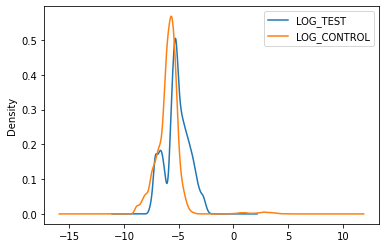

In [ ]:
predf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Kernal Density Post-Treatment

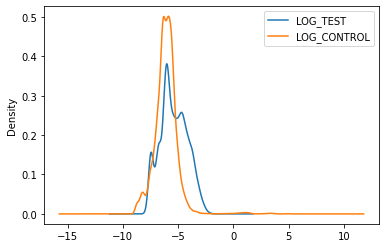

In [ ]:
postdf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Trendline

In [ ]:
fig.show()

### Difference in Difference

In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.094
Model:                                    OLS   Adj. R-squared:                  0.094
Method:                         Least Squares   F-statistic:                     2588.
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:53:42   Log-Likelihood:            -1.5740e+05
No. Observations:                       99702   AIC:                         3.148e+05
Df Residuals:                           99697   BIC:                         3.149e+05
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.9322      0.010   -603.667      0.000      -5.951      -5.913
TEST_GROUP               0.7630      0.011     72.604      0.000       0.742       0.784
TREATMENT               -0.1540      0.017     -9.222      0.000      -0.187      -0.121
TEST_GROUP:TREATMENT    -0.0682      0.015     -4.589      0.000      -0.097      -0.039
DAY_DELTA            -2.574e-05   3.53e-05     -0.728      0.466    -9.5e-05    4.35e-05
==============================================================================
Omnibus:                    39254.944   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           525833.145
Skew:                           1.524   Prob(JB):                         0.00
Kurtosis:                      13.830   Cond. No.                     2.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-5.932200,0.010000,-603.667,0.000,-5.951000,-5.913000,-593.220000
TEST_GROUP,0.763000,0.011000,72.604,0.000,0.742000,0.784000,76.300000
TREATMENT,-0.154000,0.017000,-9.222,0.000,-0.187000,-0.121000,-15.400000
TEST_GROUP:TREATMENT,-0.068200,0.015000,-4.589,0.000,-0.097000,-0.039000,-6.820000
DAY_DELTA,-0.000026,0.000035,-0.728,0.466,-0.000095,0.000044,-0.002574


### Difference in Difference in Difference- Small Cap

In [ ]:
results_summary2 = results2.summary()
results_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.327
Model:                                    OLS   Adj. R-squared:                  0.327
Method:                         Least Squares   F-statistic:                     6065.
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:53:42   Log-Likelihood:            -1.4255e+05
No. Observations:                       99702   AIC:                         2.851e+05
Df Residuals:                           99693   BIC:                         2.852e+05
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -6.3064      0.011   -572.023      0.000      -6.328      -6.285
TEST_GROUP                        0.2999      0.013     22.353      0.000       0.274       0.326
TREATMENT                        -0.0129      0.018     -0.735      0.463      -0.047       0.021
TEST_GROUP:TREATMENT             -0.2541      0.019    -13.388      0.000      -0.291      -0.217
SMALLCAP                          0.6837      0.013     53.004      0.000       0.658       0.709
SMALLCAP:TREATMENT               -0.2578      0.018    -14.132      0.000      -0.294      -0.222
SMALLCAP:TEST_GROUP               0.8621      0.018     47.412      0.000       0.827       0.898
SMALLCAP:TREATMENT:TEST_GROUP     0.3404      0.026     13.236      0.000       0.290       0.391
DAY_DELTA                     -2.574e-05   3.04e-05     -0.845      0.398   -8.54e-05    3.39e-05
==============================================================================
Omnibus:                    62241.827   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1855761.954
Skew:                           2.523   Prob(JB):                         0.00
Kurtosis:                      23.524   Cond. No.                     5.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html2 = results_summary2.tables[1].as_html()
dd= pd.read_html(results_as_html2, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-6.306400,0.01100,-572.023,0.000,-6.328000,-6.285000,-630.640000
TEST_GROUP,0.299900,0.01300,22.353,0.000,0.274000,0.326000,29.990000
TREATMENT,-0.012900,0.01800,-0.735,0.463,-0.047000,0.021000,-1.290000
TEST_GROUP:TREATMENT,-0.254100,0.01900,-13.388,0.000,-0.291000,-0.217000,-25.410000
SMALLCAP,0.683700,0.01300,53.004,0.000,0.658000,0.709000,68.370000
SMALLCAP:TREATMENT,-0.257800,0.01800,-14.132,0.000,-0.294000,-0.222000,-25.780000
SMALLCAP:TEST_GROUP,0.862100,0.01800,47.412,0.000,0.827000,0.898000,86.210000
SMALLCAP:TREATMENT:TEST_GROUP,0.340400,0.02600,13.236,0.000,0.290000,0.391000,34.040000
DAY_DELTA,-0.000026,0.00003,-0.845,0.398,-0.000085,0.000034,-0.002574


### Difference in Difference in Difference- Middle Cap

In [ ]:
results_summary3=results3.summary()
results_summary3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.170
Model:                                    OLS   Adj. R-squared:                  0.170
Method:                         Least Squares   F-statistic:                     2554.
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:53:42   Log-Likelihood:            -1.5303e+05
No. Observations:                       99702   AIC:                         3.061e+05
Df Residuals:                           99693   BIC:                         3.062e+05
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -5.8614      0.011   -536.190      0.000      -5.883      -5.840
TEST_GROUP                      1.0445      0.013     81.957      0.000       1.019       1.069
TREATMENT                      -0.2341      0.018    -13.142      0.000      -0.269      -0.199
TEST_GROUP:TREATMENT            0.0428      0.018      2.374      0.018       0.007       0.078
MIDCAP                         -0.1870      0.015    -12.722      0.000      -0.216      -0.158
MIDCAP:TREATMENT                0.2116      0.021     10.177      0.000       0.171       0.252
MIDCAP:TEST_GROUP              -0.7524      0.021    -36.252      0.000      -0.793      -0.712
MIDCAP:TREATMENT:TEST_GROUP    -0.2937      0.029    -10.007      0.000      -0.351      -0.236
DAY_DELTA                   -2.574e-05   3.38e-05     -0.761      0.447    -9.2e-05    4.06e-05
==============================================================================
Omnibus:                    41090.572   Durbin-Watson:                   0.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           790470.968
Skew:                           1.506   Prob(JB):                         0.00
Kurtosis:                      16.461   Cond. No.                     4.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html3 = results_summary3.tables[1].as_html()
dd= pd.read_html(results_as_html3, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-5.861400,0.011000,-536.190,0.000,-5.883000,-5.840000,-586.140000
TEST_GROUP,1.044500,0.013000,81.957,0.000,1.019000,1.069000,104.450000
TREATMENT,-0.234100,0.018000,-13.142,0.000,-0.269000,-0.199000,-23.410000
TEST_GROUP:TREATMENT,0.042800,0.018000,2.374,0.018,0.007000,0.078000,4.280000
MIDCAP,-0.187000,0.015000,-12.722,0.000,-0.216000,-0.158000,-18.700000
MIDCAP:TREATMENT,0.211600,0.021000,10.177,0.000,0.171000,0.252000,21.160000
MIDCAP:TEST_GROUP,-0.752400,0.021000,-36.252,0.000,-0.793000,-0.712000,-75.240000
MIDCAP:TREATMENT:TEST_GROUP,-0.293700,0.029000,-10.007,0.000,-0.351000,-0.236000,-29.370000
DAY_DELTA,-0.000026,0.000034,-0.761,0.447,-0.000092,0.000041,-0.002574


### Difference in Difference in Difference- Large Cap

In [ ]:
results_summary4=results4.summary()
results_summary4

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.278
Model:                                    OLS   Adj. R-squared:                  0.278
Method:                         Least Squares   F-statistic:                     4804.
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:53:42   Log-Likelihood:            -1.4607e+05
No. Observations:                       99702   AIC:                         2.922e+05
Df Residuals:                           99693   BIC:                         2.922e+05
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -5.7969      0.009   -646.257      0.000      -5.814      -5.779
TEST_GROUP                        0.8061      0.010     82.493      0.000       0.787       0.825
TREATMENT                        -0.1692      0.015    -11.175      0.000      -0.199      -0.139
TEST_GROUP:TREATMENT             -0.0516      0.014     -3.737      0.000      -0.079      -0.025
LARGECAP                         -1.8368      0.025    -72.153      0.000      -1.887      -1.787
LARGECAP:TREATMENT                0.2062      0.036      5.729      0.000       0.136       0.277
LARGECAP:TEST_GROUP              -0.3047      0.035     -8.719      0.000      -0.373      -0.236
LARGECAP:TREATMENT:TEST_GROUP    -0.2226      0.049     -4.504      0.000      -0.319      -0.126
DAY_DELTA                     -2.574e-05   3.15e-05     -0.816      0.415   -8.76e-05    3.61e-05
==============================================================================
Omnibus:                    55877.070   Durbin-Watson:                   0.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1209320.938
Skew:                           2.259   Prob(JB):                         0.00
Kurtosis:                      19.453   Cond. No.                     8.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html4 = results_summary4.tables[1].as_html()
dd= pd.read_html(results_as_html4, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-5.796900,0.009000,-646.257,0.000,-5.814000,-5.779000,-579.690000
TEST_GROUP,0.806100,0.010000,82.493,0.000,0.787000,0.825000,80.610000
TREATMENT,-0.169200,0.015000,-11.175,0.000,-0.199000,-0.139000,-16.920000
TEST_GROUP:TREATMENT,-0.051600,0.014000,-3.737,0.000,-0.079000,-0.025000,-5.160000
LARGECAP,-1.836800,0.025000,-72.153,0.000,-1.887000,-1.787000,-183.680000
LARGECAP:TREATMENT,0.206200,0.036000,5.729,0.000,0.136000,0.277000,20.620000
LARGECAP:TEST_GROUP,-0.304700,0.035000,-8.719,0.000,-0.373000,-0.236000,-30.470000
LARGECAP:TREATMENT:TEST_GROUP,-0.222600,0.049000,-4.504,0.000,-0.319000,-0.126000,-22.260000
DAY_DELTA,-0.000026,0.000031,-0.816,0.415,-0.000088,0.000036,-0.002574


In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     np.log(REL_BID_ASK_SPREAD)   R-squared:                       0.094
Model:                                    OLS   Adj. R-squared:                  0.094
Method:                         Least Squares   F-statistic:                     2588.
Date:                        Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                                16:53:43   Log-Likelihood:            -1.5740e+05
No. Observations:                       99702   AIC:                         3.148e+05
Df Residuals:                           99697   BIC:                         3.149e+05
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.9322      0.010   -603.667      0.000      -5.951      -5.913
TEST_GROUP               0.7630      0.011     72.604      0.000       0.742       0.784
TREATMENT               -0.1540      0.017     -9.222      0.000      -0.187      -0.121
TEST_GROUP:TREATMENT    -0.0682      0.015     -4.589      0.000      -0.097      -0.039
DAY_DELTA            -2.574e-05   3.53e-05     -0.728      0.466    -9.5e-05    4.35e-05
==============================================================================
Omnibus:                    39254.944   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           525833.145
Skew:                           1.524   Prob(JB):                         0.00
Kurtosis:                      13.830   Cond. No.                     2.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-5.932200,0.010000,-603.667,0.000,-5.951000,-5.913000,-593.220000
TEST_GROUP,0.763000,0.011000,72.604,0.000,0.742000,0.784000,76.300000
TREATMENT,-0.154000,0.017000,-9.222,0.000,-0.187000,-0.121000,-15.400000
TEST_GROUP:TREATMENT,-0.068200,0.015000,-4.589,0.000,-0.097000,-0.039000,-6.820000
DAY_DELTA,-0.000026,0.000035,-0.728,0.466,-0.000095,0.000044,-0.002574


## Analyst Bid


In [ ]:
results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats = diff_in_diff('TOT_ANALYST_REC')

### Summary Statistics

In [ ]:
predfstats

,CONTROL,TEST
count,25056.000000,25056.000000
mean,8.382663,9.870849
std,6.476709,7.922635
min,1.000000,1.000000
25%,5.000000,4.000000
50%,6.000000,8.000000
75%,10.000000,13.000000
max,35.000000,39.000000


In [ ]:
postdfstats

,CONTROL,TEST
count,25056.000000,25056.000000
mean,8.486949,9.413314
std,6.266418,7.352601
min,1.000000,1.000000
25%,5.000000,4.000000
50%,6.000000,8.000000
75%,10.000000,12.000000
max,37.000000,39.000000


### Kernal Density Pre-Treatment

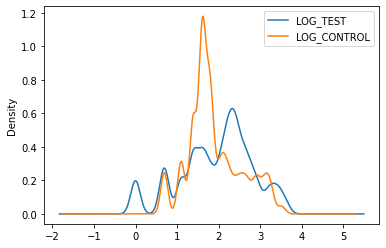

In [ ]:
predf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Kernal Density Post-Treatment

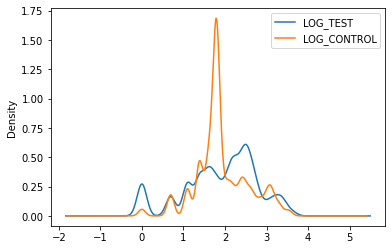

In [ ]:
postdf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Trendline

In [ ]:
fig.show()

### Difference in Difference

In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(TOT_ANALYST_REC)   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                  0.001
Method:                      Least Squares   F-statistic:                     23.26
Date:                     Thu, 18 Jun 2020   Prob (F-statistic):           3.01e-19
Time:                             16:53:49   Log-Likelihood:            -1.1555e+05
No. Observations:                   100224   AIC:                         2.311e+05
Df Residuals:                       100219   BIC:                         2.312e+05
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.9053      0.006    298.017      0.000       1.893       1.918
TEST_GROUP               0.0627      0.007      9.159      0.000       0.049       0.076
TREATMENT                0.0503      0.011      4.627      0.000       0.029       0.072
TEST_GROUP:TREATMENT    -0.0737      0.010     -7.607      0.000      -0.093      -0.055
DAY_DELTA            -5.244e-05    2.3e-05     -2.278      0.023   -9.76e-05   -7.32e-06
==============================================================================
Omnibus:                      981.743   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1012.511
Skew:                          -0.241   Prob(JB):                    1.37e-220
Kurtosis:                       3.104   Cond. No.                     2.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,1.905300,0.006000,298.017,0.000,1.893000,1.918000,190.530000
TEST_GROUP,0.062700,0.007000,9.159,0.000,0.049000,0.076000,6.270000
TREATMENT,0.050300,0.011000,4.627,0.000,0.029000,0.072000,5.030000
TEST_GROUP:TREATMENT,-0.073700,0.010000,-7.607,0.000,-0.093000,-0.055000,-7.370000
DAY_DELTA,-0.000052,0.000023,-2.278,0.023,-0.000098,-0.000007,-0.005244


### Difference in Difference in Difference- Small Cap

In [ ]:
results_summary2 = results2.summary()
results_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(TOT_ANALYST_REC)   R-squared:                       0.334
Model:                                 OLS   Adj. R-squared:                  0.334
Method:                      Least Squares   F-statistic:                     6288.
Date:                     Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                             16:53:49   Log-Likelihood:                -95209.
No. Observations:                   100224   AIC:                         1.904e+05
Df Residuals:                       100215   BIC:                         1.905e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2184      0.007    328.150      0.000       2.205       2.232
TEST_GROUP                        0.3826      0.008     46.333      0.000       0.366       0.399
TREATMENT                         0.0063      0.011      0.590      0.555      -0.015       0.027
TEST_GROUP:TREATMENT             -0.0669      0.012     -5.731      0.000      -0.090      -0.044
SMALLCAP                         -0.5781      0.008    -72.880      0.000      -0.594      -0.563
SMALLCAP:TREATMENT                0.0811      0.011      7.229      0.000       0.059       0.103
SMALLCAP:TEST_GROUP              -0.5905      0.011    -52.633      0.000      -0.612      -0.568
SMALLCAP:TREATMENT:TEST_GROUP    -0.0124      0.016     -0.784      0.433      -0.044       0.019
DAY_DELTA                     -5.244e-05   1.88e-05     -2.790      0.005   -8.93e-05   -1.56e-05
==============================================================================
Omnibus:                     1809.469   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1909.124
Skew:                          -0.338   Prob(JB):                         0.00
Kurtosis:                       3.019   Cond. No.                     5.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html2 = results_summary2.tables[1].as_html()
dd= pd.read_html(results_as_html2, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,2.218400,0.007000,328.150,0.000,2.205000,2.232000,221.840000
TEST_GROUP,0.382600,0.008000,46.333,0.000,0.366000,0.399000,38.260000
TREATMENT,0.006300,0.011000,0.590,0.555,-0.015000,0.027000,0.630000
TEST_GROUP:TREATMENT,-0.066900,0.012000,-5.731,0.000,-0.090000,-0.044000,-6.690000
SMALLCAP,-0.578100,0.008000,-72.880,0.000,-0.594000,-0.563000,-57.810000
SMALLCAP:TREATMENT,0.081100,0.011000,7.229,0.000,0.059000,0.103000,8.110000
SMALLCAP:TEST_GROUP,-0.590500,0.011000,-52.633,0.000,-0.612000,-0.568000,-59.050000
SMALLCAP:TREATMENT:TEST_GROUP,-0.012400,0.016000,-0.784,0.433,-0.044000,0.019000,-1.240000
DAY_DELTA,-0.000052,0.000019,-2.790,0.005,-0.000089,-0.000016,-0.005244


### Difference in Difference in Difference- Middle Cap

In [ ]:
results_summary3=results3.summary()
results_summary3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(TOT_ANALYST_REC)   R-squared:                       0.127
Model:                                 OLS   Adj. R-squared:                  0.127
Method:                      Least Squares   F-statistic:                     1830.
Date:                     Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                             16:53:49   Log-Likelihood:            -1.0876e+05
No. Observations:                   100224   AIC:                         2.175e+05
Df Residuals:                       100215   BIC:                         2.176e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.8239      0.007    263.313      0.000       1.810       1.837
TEST_GROUP                     -0.1577      0.008    -19.482      0.000      -0.174      -0.142
TREATMENT                       0.0746      0.011      6.604      0.000       0.052       0.097
TEST_GROUP:TREATMENT           -0.0749      0.011     -6.546      0.000      -0.097      -0.052
MIDCAP                          0.2169      0.009     23.209      0.000       0.199       0.235
MIDCAP:TREATMENT               -0.0649      0.013     -4.914      0.000      -0.091      -0.039
MIDCAP:TEST_GROUP               0.5878      0.013     44.467      0.000       0.562       0.614
MIDCAP:TREATMENT:TEST_GROUP     0.0034      0.019      0.182      0.856      -0.033       0.040
DAY_DELTA                   -5.244e-05   2.15e-05     -2.438      0.015   -9.46e-05   -1.03e-05
==============================================================================
Omnibus:                      493.297   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              608.783
Skew:                           0.098   Prob(JB):                    6.37e-133
Kurtosis:                       3.328   Cond. No.                     4.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html3 = results_summary3.tables[1].as_html()
dd= pd.read_html(results_as_html3, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,1.823900,0.007000,263.313,0.000,1.810000,1.83700,182.390000
TEST_GROUP,-0.157700,0.008000,-19.482,0.000,-0.174000,-0.14200,-15.770000
TREATMENT,0.074600,0.011000,6.604,0.000,0.052000,0.09700,7.460000
TEST_GROUP:TREATMENT,-0.074900,0.011000,-6.546,0.000,-0.097000,-0.05200,-7.490000
MIDCAP,0.216900,0.009000,23.209,0.000,0.199000,0.23500,21.690000
MIDCAP:TREATMENT,-0.064900,0.013000,-4.914,0.000,-0.091000,-0.03900,-6.490000
MIDCAP:TEST_GROUP,0.587800,0.013000,44.467,0.000,0.562000,0.61400,58.780000
MIDCAP:TREATMENT:TEST_GROUP,0.003400,0.019000,0.182,0.856,-0.033000,0.04000,0.340000
DAY_DELTA,-0.000052,0.000022,-2.438,0.015,-0.000095,-0.00001,-0.005244


### Difference in Difference in Difference- Large Cap

In [ ]:
results_summary4=results4.summary()
results_summary4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(TOT_ANALYST_REC)   R-squared:                       0.203
Model:                                 OLS   Adj. R-squared:                  0.203
Method:                      Least Squares   F-statistic:                     3200.
Date:                     Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                             16:53:50   Log-Likelihood:            -1.0419e+05
No. Observations:                   100224   AIC:                         2.084e+05
Df Residuals:                       100215   BIC:                         2.085e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.8041      0.006    308.116      0.000       1.793       1.816
TEST_GROUP                        0.0531      0.006      8.311      0.000       0.041       0.066
TREATMENT                         0.0556      0.010      5.633      0.000       0.036       0.075
TEST_GROUP:TREATMENT             -0.0762      0.009     -8.433      0.000      -0.094      -0.058
LARGECAP                          1.2134      0.016     77.573      0.000       1.183       1.244
LARGECAP:TREATMENT               -0.0643      0.022     -2.906      0.004      -0.108      -0.021
LARGECAP:TEST_GROUP               0.1157      0.022      5.231      0.000       0.072       0.159
LARGECAP:TREATMENT:TEST_GROUP     0.0300      0.031      0.958      0.338      -0.031       0.091
DAY_DELTA                     -5.244e-05   2.06e-05     -2.551      0.011   -9.27e-05   -1.22e-05
==============================================================================
Omnibus:                     2852.301   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3564.182
Skew:                          -0.351   Prob(JB):                         0.00
Kurtosis:                       3.600   Cond. No.                     8.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html4 = results_summary4.tables[1].as_html()
dd= pd.read_html(results_as_html4, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,1.804100,0.006000,308.116,0.000,1.793000,1.816000,180.410000
TEST_GROUP,0.053100,0.006000,8.311,0.000,0.041000,0.066000,5.310000
TREATMENT,0.055600,0.010000,5.633,0.000,0.036000,0.075000,5.560000
TEST_GROUP:TREATMENT,-0.076200,0.009000,-8.433,0.000,-0.094000,-0.058000,-7.620000
LARGECAP,1.213400,0.016000,77.573,0.000,1.183000,1.244000,121.340000
LARGECAP:TREATMENT,-0.064300,0.022000,-2.906,0.004,-0.108000,-0.021000,-6.430000
LARGECAP:TEST_GROUP,0.115700,0.022000,5.231,0.000,0.072000,0.159000,11.570000
LARGECAP:TREATMENT:TEST_GROUP,0.030000,0.031000,0.958,0.338,-0.031000,0.091000,3.000000
DAY_DELTA,-0.000052,0.000021,-2.551,0.011,-0.000093,-0.000012,-0.005244


## Liquidity Ratio- 3

In [ ]:
results, results2, results3, results4, predf, postdf, fig, predfstats, postdfstats = diff_in_diff('LQ3')

### Summary Statistics

In [ ]:
predfstats

,CONTROL,TEST
count,25056.000000,25056.000000
mean,0.000115,0.000968
std,0.001654,0.085053
min,-0.028536,-2.249675
25%,-0.000250,-0.001556
50%,0.000105,0.000100
75%,0.000498,0.001606
max,0.025239,4.537173


In [ ]:
postdfstats

,CONTROL,TEST
count,25056.000000,25056.000000
mean,0.000071,0.000819
std,0.002224,0.079926
min,-0.044515,-1.999700
25%,-0.000286,-0.001348
50%,0.000100,0.000100
75%,0.000502,0.001338
max,0.036767,2.999800


### Kernal Density Pre-Treatment

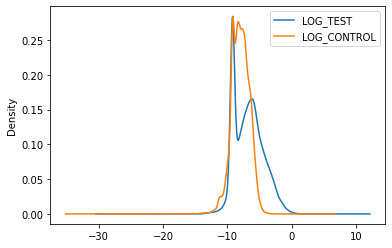

In [ ]:
predf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()


### Kernal Density Post-Treatment

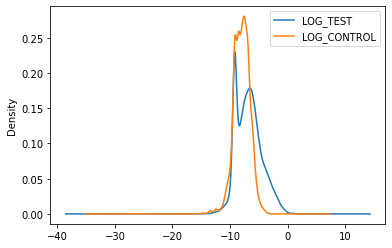

In [ ]:
postdf[['LOG_TEST', 'LOG_CONTROL']].plot.kde()

### Trendline

In [ ]:
fig.show()

### Difference in Difference

In [ ]:
results_summary = results.summary()
results_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(LQ3)   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     1617.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:55   Log-Likelihood:            -1.2010e+05
No. Observations:               59355   AIC:                         2.402e+05
Df Residuals:                   59350   BIC:                         2.403e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -7.9742      0.020   -407.747      0.000      -8.013      -7.936
TEST_GROUP               1.2319      0.021     58.447      0.000       1.191       1.273
TREATMENT                0.0438      0.033      1.313      0.189      -0.022       0.109
TEST_GROUP:TREATMENT    -0.0462      0.030     -1.537      0.124      -0.105       0.013
DAY_DELTA            -6.734e-05   7.17e-05     -0.940      0.347      -0.000    7.31e-05
==============================================================================
Omnibus:                     2368.999   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6933.960
Skew:                           0.130   Prob(JB):                         0.00
Kurtosis:                       4.654   Cond. No.                     2.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html = results_summary.tables[1].as_html()
dd = pd.read_html(results_as_html, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-7.974200,0.020000,-407.747,0.000,-8.013,-7.936000,-797.420000
TEST_GROUP,1.231900,0.021000,58.447,0.000,1.191,1.273000,123.190000
TREATMENT,0.043800,0.033000,1.313,0.189,-0.022,0.109000,4.380000
TEST_GROUP:TREATMENT,-0.046200,0.030000,-1.537,0.124,-0.105,0.013000,-4.620000
DAY_DELTA,-0.000067,0.000072,-0.940,0.347,-0.000,0.000073,-0.006734


### Difference in Difference in Difference- Small Cap

In [ ]:
results_summary2 = results2.summary()
results_summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(LQ3)   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     1148.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:55   Log-Likelihood:            -1.1890e+05
No. Observations:               59355   AIC:                         2.378e+05
Df Residuals:                   59346   BIC:                         2.379e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.0799      0.024   -333.695      0.000      -8.127      -8.032
TEST_GROUP                        0.7576      0.030     25.156      0.000       0.699       0.817
TREATMENT                         0.1299      0.039      3.323      0.001       0.053       0.207
TEST_GROUP:TREATMENT             -0.0898      0.043     -2.080      0.038      -0.174      -0.005
SMALLCAP                          0.2101      0.029      7.339      0.000       0.154       0.266
SMALLCAP:TREATMENT               -0.1525      0.041     -3.734      0.000      -0.233      -0.072
SMALLCAP:TEST_GROUP               0.8736      0.041     21.107      0.000       0.792       0.955
SMALLCAP:TREATMENT:TEST_GROUP     0.0707      0.059      1.195      0.232      -0.045       0.186
DAY_DELTA                      -8.68e-05   7.02e-05     -1.236      0.216      -0.000    5.09e-05
==============================================================================
Omnibus:                     2239.345   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6621.072
Skew:                          -0.091   Prob(JB):                         0.00
Kurtosis:                       4.626   Cond. No.                     5.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html2 = results_summary2.tables[1].as_html()
dd= pd.read_html(results_as_html2, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-8.079900,0.02400,-333.695,0.000,-8.127,-8.032000,-807.99000
TEST_GROUP,0.757600,0.03000,25.156,0.000,0.699,0.817000,75.76000
TREATMENT,0.129900,0.03900,3.323,0.001,0.053,0.207000,12.99000
TEST_GROUP:TREATMENT,-0.089800,0.04300,-2.080,0.038,-0.174,-0.005000,-8.98000
SMALLCAP,0.210100,0.02900,7.339,0.000,0.154,0.266000,21.01000
SMALLCAP:TREATMENT,-0.152500,0.04100,-3.734,0.000,-0.233,-0.072000,-15.25000
SMALLCAP:TEST_GROUP,0.873600,0.04100,21.107,0.000,0.792,0.955000,87.36000
SMALLCAP:TREATMENT:TEST_GROUP,0.070700,0.05900,1.195,0.232,-0.045,0.186000,7.07000
DAY_DELTA,-0.000087,0.00007,-1.236,0.216,-0.000,0.000051,-0.00868


### Difference in Difference in Difference- Middle Cap

In [ ]:
results_summary3=results3.summary()
results_summary3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(LQ3)   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     906.9
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:55   Log-Likelihood:            -1.1975e+05
No. Observations:               59355   AIC:                         2.395e+05
Df Residuals:                   59346   BIC:                         2.396e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -8.0146      0.022   -356.994      0.000      -8.059      -7.971
TEST_GROUP                      1.4918      0.026     56.434      0.000       1.440       1.544
TREATMENT                      -0.0062      0.037     -0.169      0.866      -0.078       0.066
TEST_GROUP:TREATMENT           -0.0202      0.038     -0.535      0.592      -0.094       0.054
MIDCAP                          0.1104      0.030      3.679      0.000       0.052       0.169
MIDCAP:TREATMENT                0.1385      0.043      3.237      0.001       0.055       0.222
MIDCAP:TEST_GROUP              -0.7000      0.043    -16.145      0.000      -0.785      -0.615
MIDCAP:TREATMENT:TEST_GROUP    -0.0816      0.062     -1.317      0.188      -0.203       0.040
DAY_DELTA                   -7.136e-05   7.12e-05     -1.002      0.317      -0.000    6.83e-05
==============================================================================
Omnibus:                     2083.720   Durbin-Watson:                   1.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6145.099
Skew:                           0.026   Prob(JB):                         0.00
Kurtosis:                       4.575   Cond. No.                     4.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html3 = results_summary3.tables[1].as_html()
dd= pd.read_html(results_as_html3, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-8.014600,0.022000,-356.994,0.000,-8.059,-7.971000,-801.460000
TEST_GROUP,1.491800,0.026000,56.434,0.000,1.440,1.544000,149.180000
TREATMENT,-0.006200,0.037000,-0.169,0.866,-0.078,0.066000,-0.620000
TEST_GROUP:TREATMENT,-0.020200,0.038000,-0.535,0.592,-0.094,0.054000,-2.020000
MIDCAP,0.110400,0.030000,3.679,0.000,0.052,0.169000,11.040000
MIDCAP:TREATMENT,0.138500,0.043000,3.237,0.001,0.055,0.222000,13.850000
MIDCAP:TEST_GROUP,-0.700000,0.043000,-16.145,0.000,-0.785,-0.615000,-70.000000
MIDCAP:TREATMENT:TEST_GROUP,-0.081600,0.062000,-1.317,0.188,-0.203,0.040000,-8.160000
DAY_DELTA,-0.000071,0.000071,-1.002,0.317,-0.000,0.000068,-0.007136


### Difference in Difference in Difference- Large Cap

In [ ]:
results_summary4=results4.summary()
results_summary4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(LQ3)   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     1134.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:53:55   Log-Likelihood:            -1.1894e+05
No. Observations:               59355   AIC:                         2.379e+05
Df Residuals:                   59346   BIC:                         2.380e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -7.8846      0.020   -397.559      0.000      -7.923      -7.846
TEST_GROUP                        1.2890      0.022     59.195      0.000       1.246       1.332
TREATMENT                         0.0408      0.033      1.218      0.223      -0.025       0.106
TEST_GROUP:TREATMENT             -0.0468      0.031     -1.507      0.132      -0.108       0.014
LARGECAP                         -0.8140      0.046    -17.629      0.000      -0.905      -0.723
LARGECAP:TREATMENT                0.0307      0.066      0.462      0.644      -0.100       0.161
LARGECAP:TEST_GROUP              -0.7864      0.070    -11.311      0.000      -0.923      -0.650
LARGECAP:TREATMENT:TEST_GROUP     0.0425      0.100      0.426      0.670      -0.153       0.238
DAY_DELTA                     -7.761e-05   7.03e-05     -1.104      0.270      -0.000    6.01e-05
==============================================================================
Omnibus:                     2478.239   Durbin-Watson:                   1.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8226.784
Skew:                           0.029   Prob(JB):                         0.00
Kurtosis:                       4.823   Cond. No.                     7.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
results_as_html4 = results_summary4.tables[1].as_html()
dd= pd.read_html(results_as_html4, header=0, index_col=0)[0]
dd['percentchange']=dd['coef']*100
dd

,coef,std err,t,P>|t|,[0.025,0.975],percentchange
Intercept,-7.884600,0.02000,-397.559,0.000,-7.923,-7.84600,-788.460000
TEST_GROUP,1.289000,0.02200,59.195,0.000,1.246,1.33200,128.900000
TREATMENT,0.040800,0.03300,1.218,0.223,-0.025,0.10600,4.080000
TEST_GROUP:TREATMENT,-0.046800,0.03100,-1.507,0.132,-0.108,0.01400,-4.680000
LARGECAP,-0.814000,0.04600,-17.629,0.000,-0.905,-0.72300,-81.400000
LARGECAP:TREATMENT,0.030700,0.06600,0.462,0.644,-0.100,0.16100,3.070000
LARGECAP:TEST_GROUP,-0.786400,0.07000,-11.311,0.000,-0.923,-0.65000,-78.640000
LARGECAP:TREATMENT:TEST_GROUP,0.042500,0.10000,0.426,0.670,-0.153,0.23800,4.250000
DAY_DELTA,-0.000078,0.00007,-1.104,0.270,-0.000,0.00006,-0.007761
